In [1]:
# Uncomment to upgrade packages
# !pip3 install pandas --upgrade --quiet
# !pip3 install numpy  --upgrade --quiet
# !pip3 install scipy --upgrade --quiet
# !pip3 install statsmodels  --upgrade --quiet
# !pip3 install seaborn  --upgrade --quiet
# !pip3 install matplotlib  --upgrade --quiet
# !pip3 install scikit-learn  --upgrade  --quiet
# !pip install scikit-optimize  --quiet
# !pip install -U --quiet yellowbrick
# !pip install apafib --upgrade  --quiet
# !pip install --upgrade pip
# !pip install ucimlrepo

In [2]:
# Imports de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns      
import missingno as msno
import statsmodels.api as sm
import matplotlib.dates as mdates

from apafib import load_dormir
from scipy import stats
from time import time
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import copy


import warnings
warnings.filterwarnings('ignore')

# Definiciones
RND = 16
MAX_ITER = 5000

sns.set(style="whitegrid", font_scale=1.05)

# Funciones auxiliares
def format_pval(p):
    if p == 0:
        return r"$0$"
    exp = int(np.floor(np.log10(p)))
    if exp >= -3:
        return f"{p:.4f}"                
    else:
        mant = p / (10.0**exp)
        return rf"${mant:.2f}\times10^{{{exp}}}$"
    
# quitar warnings:
import warnings
warnings.filterwarnings("ignore", message="findfont:.*")

init_time = time()

# Práctica de APA. Preprocesado de las variables.

## Introducción

Autores: Oriol Farrés y Marc Gil

Al tratarse de un problema de series temporales y disponer de los datos íntegramente de los años 2011 a 2024, dividiremos de la siguiente manera:

* Train Set: Años 2011 a 2020 (10 años)
* Test Set: Años 2021 a 2024 (4 años)

Es decir un ratio de aproximadamente ~70% para el conjunto de entrenamiento y un ~30% para el conjunto de test.

---

Al tener tal cantidad de trabajo con el preprocesado de las variables para el problema, para asegurarnos de que hay consistencia y evitar cometer errores metodológicos, seguiremos la siguiente estructura (basada en la lista propuesta en el LAB y en el guión de la práctica): 




**Fase A: Obtención de los datos**

1. Preámbulo

**Fase B: Limpieza de los datos**

1. Preparar las variables (Sanity Check)
2. Tratamiento de valores incoherentes o incorrectos
3. Tratamiento de missing values
4. Tratamiento de outliers
5. Crear nuevas variables que pueden ser interesantes (Feature engineering)
6. Re-nombrado de las variables
7. Feature engineering (computar diferencias)
8. Eliminar data leakage

**Fase C: Separación de los datos**

1. División del dataset en train/test 

**Fase D: Análisis**

1. Exploratorio Mínimo


**Fase Final: Guardar dataset limpio**

---

Tras hacer todas estas transformaciones, guardaré utilizando **parquet**, para poder guardar en un mejor formato y mantener los tipos (csv no lo permite), un fichero ``clean_atp_matches.parquet``.

<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Fase A-Obtención de los datos

## A.1-Preámbulo

> Tenemos todo el dataset preparado en el directorio data/raw/raw_atp_matches.csv.

In [3]:
tennis = pd.read_csv('./data/raw/raw_atp_matches.csv')
tennis.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year,month,day,month_name,tourney_points
0,2011-339,Brisbane,Hard,32,A,20110102,1,104417,1.0,NaN,...,4.0,5.0,5580.0,173.0,309.0,2011,1,2,January,250
1,2011-339,Brisbane,Hard,32,A,20110102,2,103582,NaN,NaN,...,5.0,58.0,835.0,75.0,643.0,2011,1,2,January,250
2,2011-339,Brisbane,Hard,32,A,20110102,3,105051,NaN,Q,...,8.0,196.0,263.0,204.0,243.0,2011,1,2,January,250
3,2011-339,Brisbane,Hard,32,A,20110102,4,104797,8.0,NaN,...,3.0,40.0,1031.0,43.0,975.0,2011,1,2,January,250
4,2011-339,Brisbane,Hard,32,A,20110102,5,103888,4.0,NaN,...,6.0,16.0,1991.0,83.0,600.0,2011,1,2,January,250


In [4]:
tennis.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
tourney_id,39541,1894,2011-580,127,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tourney_name,39541,1078,Australian Open,1778,NaN,NaN,NaN,NaN,NaN,NaN,NaN
surface,39488,4,Hard,23060,NaN,NaN,NaN,NaN,NaN,NaN,NaN
draw_size,39541.0,NaN,NaN,NaN,57.467489,42.144138,2.0,32.0,32.0,96.0,128.0
tourney_level,39541,6,A,21148,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tourney_date,39541.0,NaN,NaN,NaN,20174404.064313,41143.884302,20110102.0,20140319.0,20170731.0,20210726.0,20241218.0
match_num,39541.0,NaN,NaN,NaN,167.239802,151.260611,1.0,21.0,190.0,283.0,1701.0
winner_id,39541.0,NaN,NaN,NaN,117737.747477,29694.476989,100644.0,104607.0,105373.0,109739.0,212721.0
winner_seed,16884.0,NaN,NaN,NaN,7.543592,6.988957,1.0,3.0,5.0,9.0,33.0
winner_entry,5347,10,Q,2968,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Fase B-Limpieza de los datos

Antes de empezar con la limpieza, vamos a ver cuantas filas tenemos en el dataset, para asegurarnos de que no cometemos ningún error.

In [5]:
print(f"Nuestro dataset tiene {tennis.shape[1]} variables y {tennis.shape[0]:,} columnas.")

Nuestro dataset tiene 54 variables y 39,541 columnas.


## B.1-Preparar las variables (Sanity Check)

En este apartado, vamos a preparnos las variables para poder tratarlas correctamente en los siguientes pasos. Un primer paso es eliminar aquellos partidos donde el rival se ha retirado/no se ha presentado, ya que esto es, obviamente impredecible (almenos con nuestros datos), y solo confundiría al modelo.

### B.1-Paso 1. Eliminar partidos inválidos

In [6]:
tennis['score'].head()

0           6-2 6-4
1    1-6 7-6(3) 6-2
2       4-6 6-2 6-4
3        7-6(5) 6-4
4           6-1 6-4
Name: score, dtype: object

In [7]:
# 1. Ver los 20 resultados más comunes (para ver lo "normal")
print("Lo normal:")
print(tennis['score'].value_counts().head(10))

print("\n----------------\n")

# 2. TRUCO PRO: Buscar solo los scores que contienen letras
# Esto te mostrará de golpe todos los RET, W/O, Def, etc.
scores_con_letras = tennis[tennis['score'].str.contains('[a-zA-Z]', na=False)]['score']

print("Lo sospechoso (contiene letras):")
print(scores_con_letras.unique())

Lo normal:
score
6-3 6-4    1355
6-4 6-4    1330
6-3 6-2     849
6-4 6-3     803
6-4 6-2     787
6-3 6-3     728
6-2 6-4     632
6-2 6-2     548
6-2 6-3     499
6-1 6-4     432
Name: count, dtype: int64

----------------

Lo sospechoso (contiene letras):
['6-2 RET' '6-0 5-0 RET' '6-3 6-1 4-2 RET' '6-1 6-0 2-0 RET'
 '6-7(5) 6-2 6-1 4-3 RET' 'W/O' '5-2 RET' '6-2 1-0 RET' '6-1 0-1 RET'
 '3-6 6-5 RET' '4-0 RET' '6-1 2-0 RET' '5-0 RET' '6-7(5) 6-2 4-2 RET'
 '4-5 RET' '6-2 4-1 RET' '6-4 RET' '7-5 2-0 RET' '5-4 RET' '6-1 5-3 RET'
 '6-4 3-1 RET' '3-0 RET' '3-4 RET' '3-6 2-1 RET' '4-6 6-1 2-0 RET'
 '2-6 4-2 RET' '5-1 RET' '6-3 4-0 RET' '4-6 6-1 4-4 RET'
 '7-6(6) 3-6 5-2 RET' '6-2 3-0 RET' '6-7(5) 6-3 3-0 RET' '6-4 1-0 RET'
 '7-6(1) 1-0 RET' '6-2 2-0 RET' '4-6 6-3 6-2 3-1 RET' '6-4 6-1 2-3 RET'
 '4-3 RET' '6-4 6-6 RET' '7-6(5) 2-0 RET' '6-7(4) 6-4 3-0 RET'
 '7-6(5) 3-6 5-3 RET' '7-5 3-1 RET' '6-3 6-3 RET' '6-4 4-2 RET' '2-3 RET'
 '6-3 6-7(5) 6-2 1-1 RET' '6-7 6-3 6-1 RET' '2-6 6-2 6-3 2-0 RET'
 

In [8]:
# 1. Copia de seguridad inicial (opcional, pero recomendada)
print(f"Total partidos antes de limpiar score: {len(tennis)}")

# 2. Asegurar que la columna sea tipo string (texto) para que no falle el filtro
tennis['score'] = tennis['score'].astype(str)

# 3. Crear el filtro de "Marcadores Sucios"
# Buscamos: 'W/O' (No presentado), 'RET' (Retirado), 'Def' (Descalificado)
# case=False detecta tanto 'Ret' como 'RET'
filtro_score_sucio = tennis['score'].str.contains('W/O|RET|Def|Walkover|Aban|ABD', case=False, na=False)

# 4. Ver qué vamos a eliminar (para que te quedes tranquilo)
print("\nEjemplos de scores que vamos a ELIMINAR:")
print(tennis[filtro_score_sucio]['score'].unique()[:10]) # Mostramos los 10 primeros tipos

# 5. Aplicar el borrado
# El símbolo '~' significa "Quédate con lo que NO es sucio"
tennis = tennis[~filtro_score_sucio].copy()

# 6. Resetear el índice
tennis.reset_index(drop=True, inplace=True)

print(f"\nTotal partidos después de limpiar score: {len(tennis)}")

Total partidos antes de limpiar score: 39541

Ejemplos de scores que vamos a ELIMINAR:
['6-2 RET' '6-0 5-0 RET' '6-3 6-1 4-2 RET' '6-1 6-0 2-0 RET'
 '6-7(5) 6-2 6-1 4-3 RET' 'W/O' '5-2 RET' '6-2 1-0 RET' '6-1 0-1 RET'
 '3-6 6-5 RET']

Total partidos después de limpiar score: 38143


In [9]:
scores_con_letras = tennis[tennis['score'].str.contains('[a-zA-Z]', na=False)]['score']

print("Lo sospechoso (contiene letras):")
print(scores_con_letras.unique())

Lo sospechoso (contiene letras):
[]


---

### B.1-Paso 2. Tratar variables temporales

In [10]:
tennis['tourney_date'].head()

0    20110102
1    20110102
2    20110102
3    20110102
4    20110102
Name: tourney_date, dtype: int64

Los datos vienen como enteros, vamos a tratarlos como datas.

In [11]:
tennis['tourney_date'] = pd.to_datetime(tennis['tourney_date'].astype(int).astype(str), format='%Y%m%d')
tennis['tourney_date'].head()

0   2011-01-02
1   2011-01-02
2   2011-01-02
3   2011-01-02
4   2011-01-02
Name: tourney_date, dtype: datetime64[ns]

In [12]:
# Extraer Año y Mes (muy útil para Análisis Exploratorio después)
tennis['year'] = tennis['tourney_date'].dt.year
tennis['month'] = tennis['tourney_date'].dt.month

In [13]:
# Ahora que tenemos fechas reales, ordenamos todo el dataset por fecha.
tennis = tennis.sort_values(by='tourney_date').reset_index(drop=True)

---
---

## B.2-Tratamiento de valores incoherentes o incorrectos

In [14]:
tennis.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
tourney_id,38143,1894,2023-540,126,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tourney_name,38143,1078,Roland Garros,1723,NaN,NaN,NaN,NaN,NaN,NaN,NaN
surface,38092,4,Hard,22196,NaN,NaN,NaN,NaN,NaN,NaN,NaN
draw_size,38143.0,NaN,NaN,NaN,57.351493,2.0,32.0,32.0,96.0,128.0,42.106182
tourney_level,38143,6,A,20413,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tourney_date,38143,NaN,NaN,NaN,2017-10-25 17:39:49.838240256,2011-01-02 00:00:00,2014-04-04 00:00:00,2017-07-31 00:00:00,2021-08-02 00:00:00,2024-12-18 00:00:00,NaN
match_num,38143.0,NaN,NaN,NaN,167.72805,1.0,21.0,191.0,283.0,1701.0,151.672994
winner_id,38143.0,NaN,NaN,NaN,117711.416643,100644.0,104607.0,105373.0,110602.0,212721.0,29639.107848
winner_seed,16345.0,NaN,NaN,NaN,7.531722,1.0,3.0,5.0,9.0,33.0,6.983197
winner_entry,5130,10,Q,2857,NaN,NaN,NaN,NaN,NaN,NaN,NaN



1. **El "Tenista Hormiga" (Alturas Imposibles):**
* Fíjate en **`winner_ht`** y **`loser_ht`**.
* El **`min` es `3.0**`.
* ¡Nadie mide 3 centímetros! Esto confirma que **aún hay datos sucios en la altura**. El código que preparamos para convertir `< 140` a `NaN` es imprescindible aquí.

### B.2-Paso 1. Arreglar alturas.

In [15]:
# Definimos el umbral de corte (160 cm es muy bajito para ATP)
umbral_altura = 160

# 1. Filtramos las filas donde el ganador O el perdedor miden menos de eso
# Nota: Pandas ignora automáticamente los NaNs en esta comparación (<), así que solo nos dará los números reales bajos.
mask_bajos = (tennis['winner_ht'] < umbral_altura) | (tennis['loser_ht'] < umbral_altura)

# 2. Seleccionamos solo las columnas relevantes para ver nombres y alturas
cols_interes = ['tourney_date', 'winner_name', 'winner_ht', 'loser_name', 'loser_ht', 'score']

# 3. Mostramos los resultados
sospechosos = tennis.loc[mask_bajos, cols_interes]

print(f"Se encontraron {len(sospechosos)} registros con alturas < {umbral_altura}cm:")
display(sospechosos.head(10)) # Muestra los primeros 10

# 4. Ver nombres únicos de los jugadores con alturas erróneas
# Esto es útil para ver si es un error sistemático con un jugador concreto
nombres_w = tennis.loc[tennis['winner_ht'] < umbral_altura, 'winner_name'].unique()
nombres_l = tennis.loc[tennis['loser_ht'] < umbral_altura, 'loser_name'].unique()

print("\nJugadores con altura errónea en columna winner:", nombres_w)
print("Jugadores con altura errónea en columna loser:", nombres_l)

Se encontraron 11 registros con alturas < 160cm:


,tourney_date,winner_name,winner_ht,loser_name,loser_ht,score
5338,2012-09-14,Roberto Quiroz,193.0,Jorge Brian Panta Herreros,3.0,7-6(8) 6-1
6088,2013-02-01,Jorge Brian Panta Herreros,3.0,Hillel Rousseau,180.0,6-1 6-0
6702,2013-04-05,Luis David Martinez,178.0,Jorge Brian Panta Herreros,3.0,3-6 7-6(4) 6-3
14865,2016-03-04,Jorge Brian Panta Herreros,3.0,Martin Cuevas,191.0,5-7 7-5 6-7(5) 7-6(4) 6-4
20155,2018-02-03,Jorge Brian Panta Herreros,3.0,Alejandro Mendoza,183.0,6-2 6-4
28928,2021-09-17,Kasidit Samrej,191.0,Johannes Ingildsen,15.0,7-5 6-3
30107,2022-03-04,Ramkumar Ramanathan,188.0,Johannes Ingildsen,15.0,5-7 7-5 [10-7]
31691,2022-09-15,Marton Fucsovics,188.0,Viacheslav Bielinskyi,71.0,6-3 6-2
31761,2022-09-17,Johannes Ingildsen,15.0,Cesar Cruz,NaN,6-4 6-4
32590,2023-02-03,Viacheslav Bielinskyi,71.0,Benjamin Hassan,183.0,6-4 2-6 6-4



Jugadores con altura errónea en columna winner: ['Jorge Brian Panta Herreros' 'Johannes Ingildsen' 'Viacheslav Bielinskyi']
Jugadores con altura errónea en columna loser: ['Jorge Brian Panta Herreros' 'Johannes Ingildsen' 'Viacheslav Bielinskyi']


Al tratarse de solo 3 jugadores los buscaremos y los copiaremos de google.

* Altura de Jorge: 173cm. [Referencia.](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjo8O662daRAxVAUaQEHXiVMSwQFnoECBgQAQ&url=https%3A%2F%2Fwww.tennislive.net%2Fatp%2Fjorge-brian-panta-herreros-nicolas-santos%2F&usg=AOvVaw1GpkG345njnwVcC5Om5v6v&opi=89978449)
* Altura de Johannes: 193cm. [Referencia.](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwid9bH62daRAxXwQqQEHRZ_FJoQFnoECB8QAQ&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FJohannes_Ingildsen&usg=AOvVaw02tZ406wYX5Gw0X2GgEQPV&opi=89978449)
* Altura de Viacheslav: No hay datos. [Referencia.](https://www.atptour.com/en/players/viacheslav-bielinskyi/b0ll/overview)

In [16]:
import numpy as np

# --- 1. CORRECCIÓN QUIRÚRGICA (Manual) ---
# Definimos los arreglos manuales basados en tu investigación
arreglos_manuales = {
    'Jorge Brian Panta Herreros': 173,
    'Johannes Ingildsen': 193
}

# Aplicamos los cambios tanto si aparecen como Winner como si aparecen como Loser
for rol in ['winner', 'loser']:
    col_name = f'{rol}_name'
    col_ht = f'{rol}_ht'
    
    # A) Aplicar correcciones de altura conocidas (Jorge y Johannes)
    for nombre, altura_real in arreglos_manuales.items():
        # Buscamos dónde está ese jugador y le asignamos su altura real
        mask = tennis[col_name] == nombre
        tennis.loc[mask, col_ht] = altura_real
        
    # B) CASO ESPECIAL: Viacheslav Bielinskyi
    # Como los datos oficiales están corruptos (150cm/151kg), lo mejor es borrar el dato
    # y dejar que la imputación (media global) se encargue después.
    mask_viacheslav = tennis[col_name] == 'Viacheslav Bielinskyi'
    tennis.loc[mask_viacheslav, col_ht] = np.nan


# --- 2. RED DE SEGURIDAD (Automática) ---
# Cualquier otro valor por debajo de 160cm que se nos haya pasado, lo matamos.
# Esto cubrirá los '3.0', '15.0', etc. que vimos en tu captura.

umbral_minimo = 160

tennis.loc[tennis['winner_ht'] < umbral_minimo, 'winner_ht'] = np.nan
tennis.loc[tennis['loser_ht'] < umbral_minimo, 'loser_ht'] = np.nan


# --- VERIFICACIÓN FINAL ---
print("Correcciones aplicadas.")
# Verificamos que Viacheslav ahora tenga NaN (para ser imputado luego)
check_viacheslav = tennis[tennis['winner_name'] == 'Viacheslav Bielinskyi'][['winner_name', 'winner_ht']].head(1)
print(f"\nEstado de Viacheslav (debe ser NaN):\n{check_viacheslav}")

# Verificamos si queda alguien bajito
restantes = tennis[(tennis['winner_ht'] < umbral_minimo) | (tennis['loser_ht'] < umbral_minimo)]
print(f"\nJugadores restantes con altura < {umbral_minimo}cm: {len(restantes)}")

Correcciones aplicadas.

Estado de Viacheslav (debe ser NaN):
                 winner_name  winner_ht
32590  Viacheslav Bielinskyi        NaN

Jugadores restantes con altura < 160cm: 0


In [17]:
# Definimos el umbral de corte (160 cm es muy bajito para ATP)
umbral_altura = 160

# 1. Filtramos las filas donde el ganador O el perdedor miden menos de eso
# Nota: Pandas ignora automáticamente los NaNs en esta comparación (<), así que solo nos dará los números reales bajos.
mask_bajos = (tennis['winner_ht'] < umbral_altura) | (tennis['loser_ht'] < umbral_altura)

# 2. Seleccionamos solo las columnas relevantes para ver nombres y alturas
cols_interes = ['tourney_date', 'winner_name', 'winner_ht', 'loser_name', 'loser_ht', 'score']

# 3. Mostramos los resultados
sospechosos = tennis.loc[mask_bajos, cols_interes]

print(f"Se encontraron {len(sospechosos)} registros con alturas < {umbral_altura}cm:")
display(sospechosos.head(10)) # Muestra los primeros 10

# 4. Ver nombres únicos de los jugadores con alturas erróneas
# Esto es útil para ver si es un error sistemático con un jugador concreto
nombres_w = tennis.loc[tennis['winner_ht'] < umbral_altura, 'winner_name'].unique()
nombres_l = tennis.loc[tennis['loser_ht'] < umbral_altura, 'loser_name'].unique()

print("\nJugadores con altura errónea en columna winner:", nombres_w)
print("Jugadores con altura errónea en columna loser:", nombres_l)

Se encontraron 0 registros con alturas < 160cm:


,tourney_date,winner_name,winner_ht,loser_name,loser_ht,score



Jugadores con altura errónea en columna winner: []
Jugadores con altura errónea en columna loser: []


---

### B.2-Paso 2. Arreglar partidos con 0 minutos.

Asumiremos, que no hay partidos más rápidos de 25 minutos (el partido más rápido de la historia de la Era Open fue en 2001 y duró 25 minutos). [Referencia.](https://en.wikipedia.org/wiki/Shortest_tennis_match_records#:~:text=Francisco%20Clavet%20set%20an%20ATP,–0%2C%206–0.)

In [18]:
import numpy as np

# --- B.2.2 CORRECCIÓN DE MINUTOS ---

# Definimos el umbral histórico: Jarkko Nieminen ganó en 28 minutos en 2014, 
# y Francisco Clavet en 25 minutos en 2001.
# Asumimos que cualquier cosa < 25 minutos es un error de dato (o un 0).
umbral_minutos = 25

# 1. Contamos cuántos casos vamos a afectar
# Usamos fillna(-1) temporalmente en la condición para que no falle si ya hay NaNs
mask_minutos_malos = (tennis['minutes'].fillna(-1) >= 0) & (tennis['minutes'] < umbral_minutos)
num_errores = mask_minutos_malos.sum()

print(f"Se detectaron {num_errores} partidos con duración menor a {umbral_minutos} minutos.")

if num_errores > 0:
    # Mostramos algunos ejemplos antes de corregir
    print("Ejemplos de duraciones erróneas:")
    print(tennis.loc[mask_minutos_malos, ['tourney_date', 'score', 'minutes']].head())

    # 2. Aplicamos la corrección: Convertir a NaN
    tennis.loc[mask_minutos_malos, 'minutes'] = np.nan
    print(f"\nCorrección aplicada: {num_errores} valores convertidos a NaN para futura imputación.")
else:
    print("No se encontraron duraciones imposibles.")

# Verificación final
print(f"Mínimo de minutos actual en el dataset: {tennis['minutes'].min()}")

Se detectaron 0 partidos con duración menor a 25 minutos.
No se encontraron duraciones imposibles.
Mínimo de minutos actual en el dataset: 28.0


---
---

## B.3-Tratamiento de missing values

Vamos a empezar visualizando la msno.

In [19]:
# Calcular porcentaje de nulos por columna
nulos = tennis.isna().sum()
porcentaje_nulos = (nulos / len(tennis)) * 100

# Filtrar: Mostrar solo las columnas que tienen ALGÚN nulo y ordenar de mayor a menor
nulos_visibles = porcentaje_nulos[porcentaje_nulos > 0].sort_values(ascending=False)

print("Porcentaje de valores ausentes por variable:")
print(nulos_visibles)

Porcentaje de valores ausentes por variable:
winner_entry          86.550612
loser_entry           78.095588
loser_seed            76.019191
winner_seed           57.148101
minutes                9.797342
l_SvGms                5.497732
w_SvGms                5.497732
l_1stWon               5.495111
w_svpt                 5.495111
w_1stWon               5.495111
w_1stIn                5.495111
w_2ndWon               5.495111
l_df                   5.495111
w_bpSaved              5.495111
w_bpFaced              5.495111
w_ace                  5.495111
w_df                   5.495111
l_1stIn                5.495111
l_2ndWon               5.495111
l_bpSaved              5.495111
l_bpFaced              5.495111
l_ace                  5.495111
l_svpt                 5.495111
loser_ht               2.480141
loser_rank_points      1.580893
loser_rank             1.580893
winner_ht              1.051307
winner_rank            0.600372
winner_rank_points     0.600372
surface                0.13

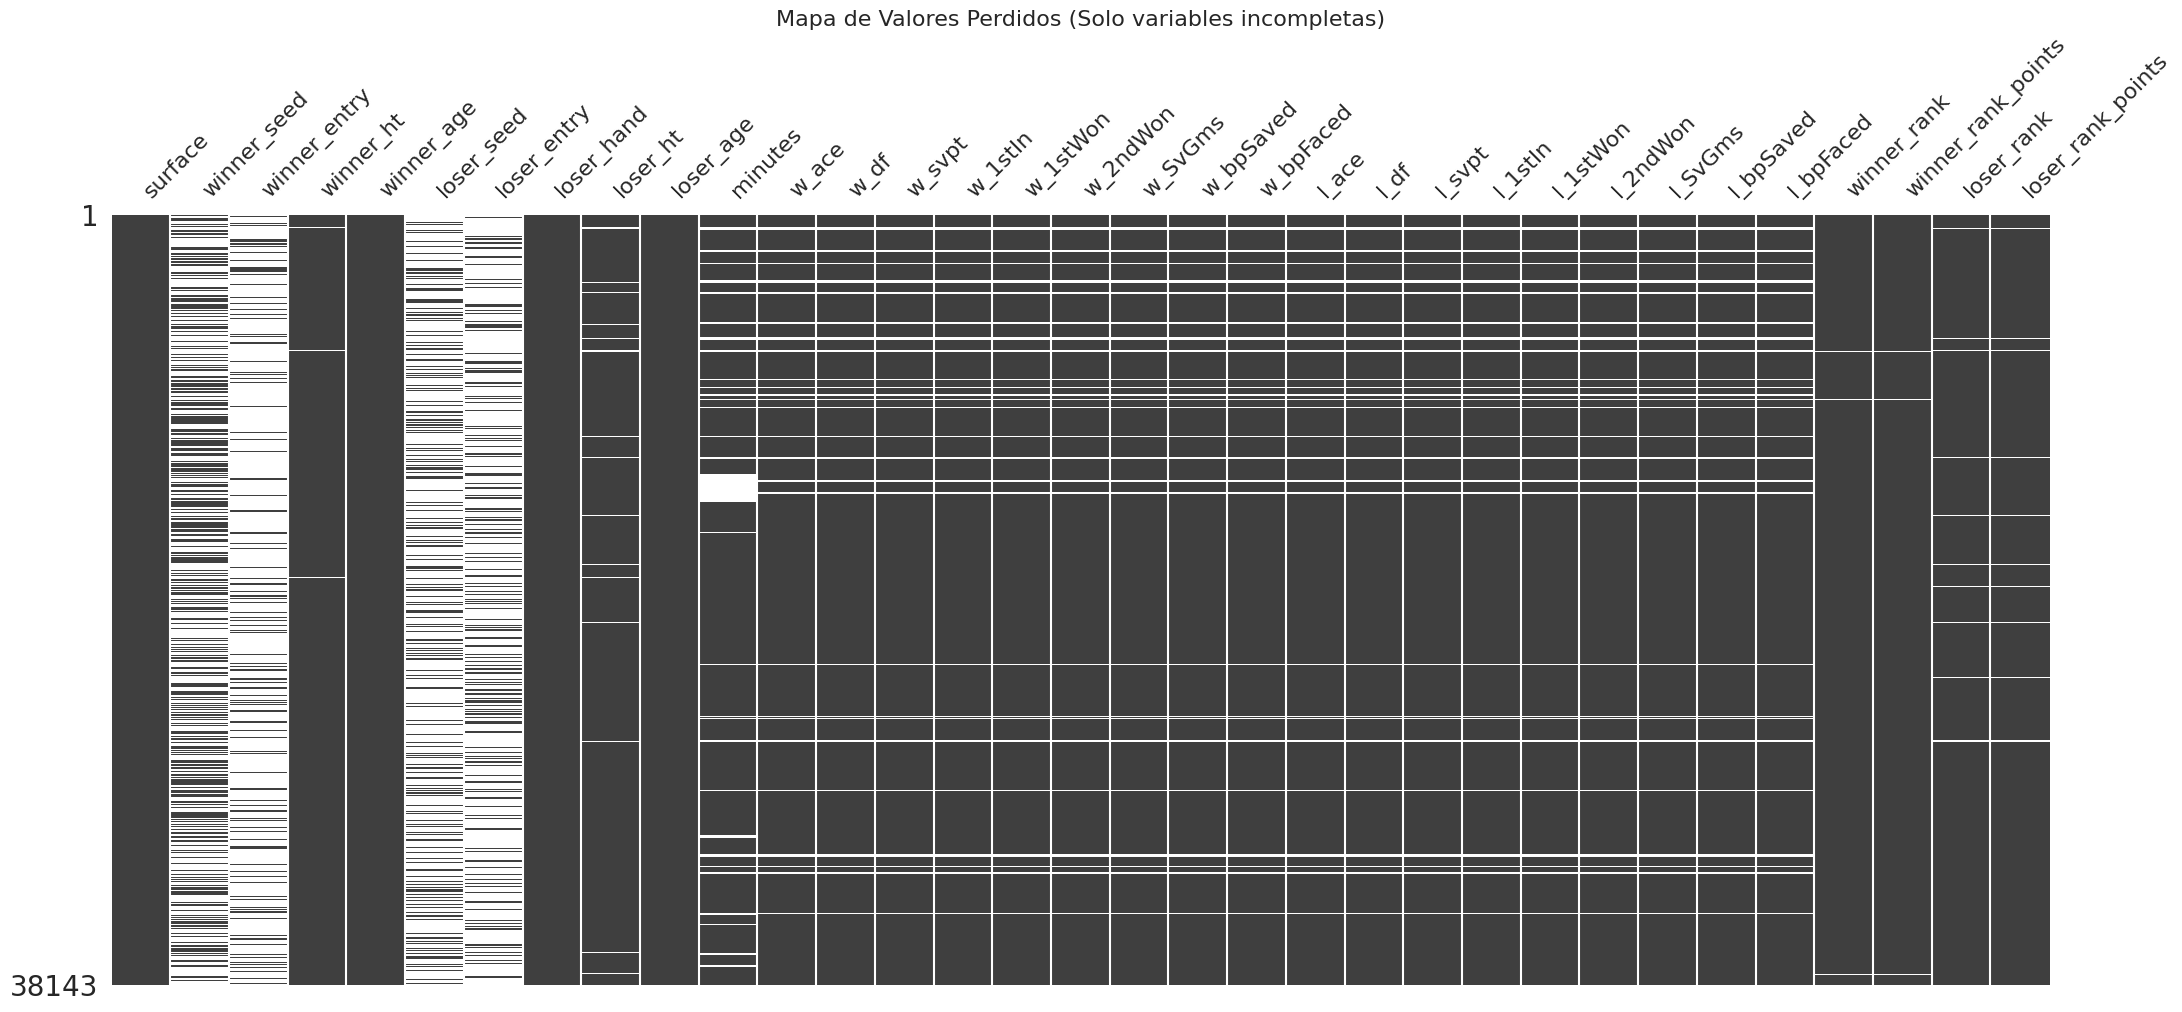

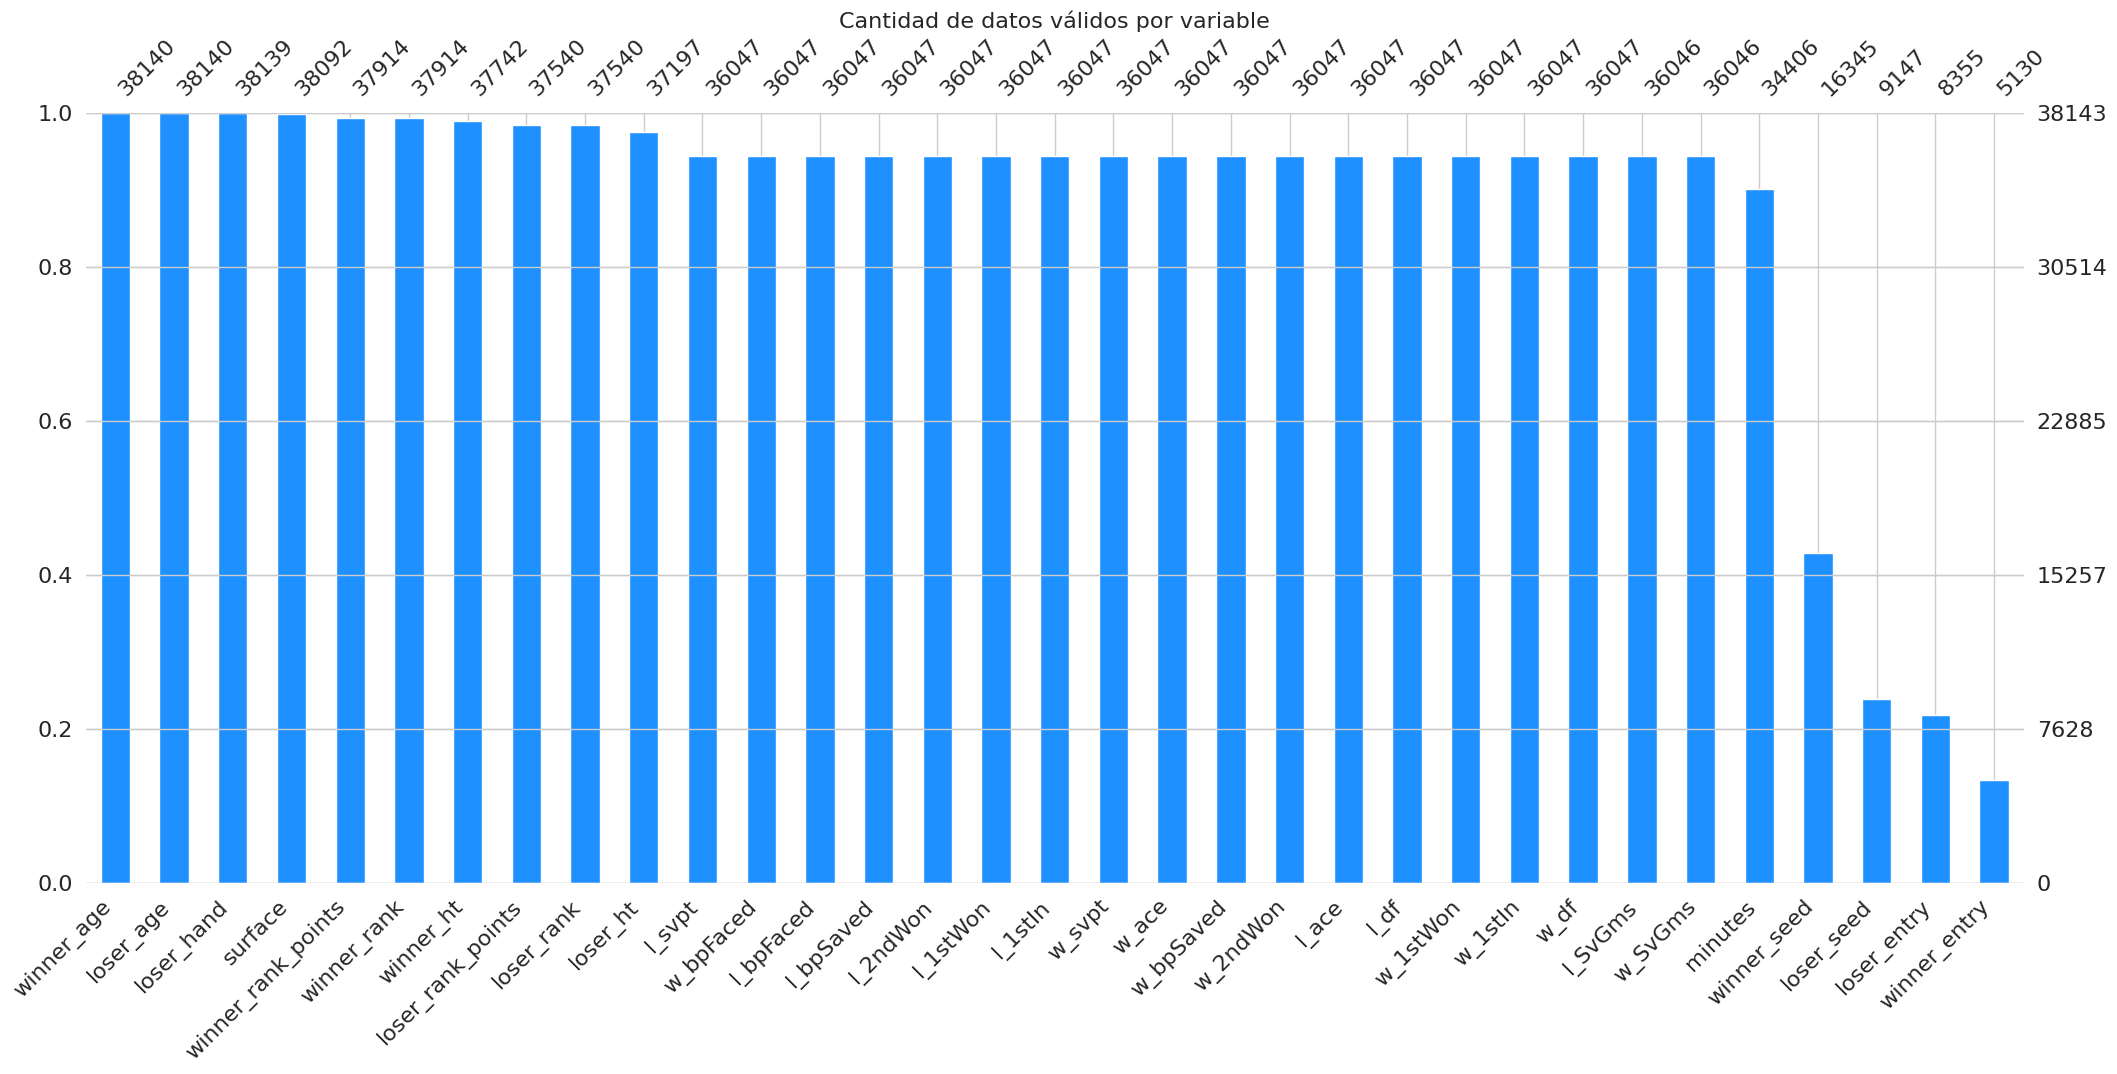

In [20]:
import missingno as msno
import matplotlib.pyplot as plt

# 1. Identificar las columnas que tienen nulos
cols_con_nulos = tennis.columns[tennis.isna().any()].tolist()

# 2. Pintar la matriz SOLO con esas columnas
# labels=True nos deja ver los nombres
msno.matrix(tennis[cols_con_nulos], labels=True, sparkline=False)
plt.title("Mapa de Valores Perdidos (Solo variables incompletas)", fontsize=16)
plt.show()

# Gráfico de barras de las variables con nulos
msno.bar(tennis[cols_con_nulos], sort='descending', color='dodgerblue')
plt.title("Cantidad de datos válidos por variable", fontsize=16)
plt.show()

No nos queda otra, que tratar cada una de las variables una por una.

### B.3-Paso 1. Edad

In [21]:
# 1. Identificar jugadores con edad faltante (Winner o Loser)
nulos_w = tennis[tennis['winner_age'].isna()]['winner_name']
nulos_l = tennis[tennis['loser_age'].isna()]['loser_name']

# Unimos las dos listas y sacamos los únicos
jugadores_sin_edad = pd.concat([nulos_w, nulos_l]).unique()

print(f"Hay {len(jugadores_sin_edad)} jugadores sin edad.")
print("Lista de jugadores para buscar en Google:")
for jugador in jugadores_sin_edad:
    print(f"- {jugador}")

Hay 4 jugadores sin edad.
Lista de jugadores para buscar en Google:
- Ari Fahresi
- Luis Carlos Alvarez Valdes
- Diego Duran
- Hamza Karmoussi



* **Ari Fahresi:** August 2, 2002 [Link](https://www.tennisexplorer.com/player/fahresi/#:~:text=Country%3A%20Indonesia,Plays%3A%20right)
* **Luis Carlos Álvarez Valdés:** September 3, 2004 [Link](https://www.atptour.com/en/players/diego-duran/d0fo/overview#:~:text=Personal%20details,(2004%2F12%2F10))
* **Diego Durán:** December 10, 2004 [Link](https://www.tennisexplorer.com/player/duran-fd3b3/#:~:text=Diego%20(2004)%20Duran%20%2D%20Tennis,Plays%3A%20right)
* **Hamza Karmoussi:** November 26, 1993 [Link](https://www.atptour.com/en/players/hamza-karmoussi/ke25/overview#:~:text=Personal%20details,(1993%2F11%2F26))

In [22]:
# --- B.3.1 CORRECCIÓN MANUAL DE EDADES (Hard-coding inteligente) ---

# Diccionario con las fechas de nacimiento reales
fechas_nacimiento = {
    'Ari Fahresi': '2002-08-02',
    'Luis Carlos Alvarez Valdes': '2004-09-03', # Note: I removed accents just in case the dataset has them plain
    'Diego Duran': '2004-12-10',                # Same here
    'Hamza Karmoussi': '1993-11-26'
}

# Bucle mágico: Calcula la edad exacta basándose en el día del partido
print("Calculando edades exactas para los jugadores sin datos...")

count = 0
for nombre, fecha_nac in fechas_nacimiento.items():
    # Convertimos la fecha de nacimiento a datetime
    dob = pd.to_datetime(fecha_nac)
    
    # 1. Corregir donde aparece como WINNER
    # Usamos 'contains' para ser flexibles con tildes (Alvarez vs Álvarez)
    mask_w = tennis['winner_name'].str.contains(nombre, case=False, regex=False)
    if mask_w.sum() > 0:
        tennis.loc[mask_w, 'winner_age'] = (tennis.loc[mask_w, 'tourney_date'] - dob).dt.days / 365.25
        count += mask_w.sum()
    
    # 2. Corregir donde aparece como LOSER
    mask_l = tennis['loser_name'].str.contains(nombre, case=False, regex=False)
    if mask_l.sum() > 0:
        tennis.loc[mask_l, 'loser_age'] = (tennis.loc[mask_l, 'tourney_date'] - dob).dt.days / 365.25
        count += mask_l.sum()

print(f"¡Éxito! Se han recuperado y calculado {count} edades exactas.")

# --- RED DE SEGURIDAD FINAL ---
# Por si acaso quedó alguno suelto (ej. un typo en el nombre), rellenamos el resto con la media.
# Esto asegura que no queden NaNs que rompan el modelo.
media_edad = pd.concat([tennis['winner_age'], tennis['loser_age']]).mean()
nulos_restantes = tennis['winner_age'].isna().sum() + tennis['loser_age'].isna().sum()

if nulos_restantes > 0:
    tennis['winner_age'] = tennis['winner_age'].fillna(media_edad)
    tennis['loser_age'] = tennis['loser_age'].fillna(media_edad)
    print(f"Aviso: Quedaban {nulos_restantes} registros sin edad. Se han rellenado con la media global ({media_edad:.2f}).")
else:
    print("Todos las edades están completas. 0 Nulos.")

Calculando edades exactas para los jugadores sin datos...
¡Éxito! Se han recuperado y calculado 6 edades exactas.
Todos las edades están completas. 0 Nulos.


---

### B.3-Paso 2. Mano.

In [23]:
# --- INSPECCIÓN DE LA MANO (HAND) ---

# 1. Buscar específicamente los NaNs (Vacíos)
filas_nulas = tennis[tennis['loser_hand'].isna()]

print(f"--- Se encontraron {len(filas_nulas)} filas con NaN en loser_hand ---")
if len(filas_nulas) > 0:
    display(filas_nulas[['tourney_date', 'loser_name', 'loser_id', 'loser_hand']])
    nombres_nan = filas_nulas['loser_name'].unique()
    print(f"\nJugadores con NaN: {nombres_nan}")

# 2. Buscar específicamente los 'U' (Unknown)
filas_unknown = tennis[tennis['loser_hand'] == 'U']
print(f"\n--- Se encontraron {len(filas_unknown)} filas con etiqueta 'U' ---")
# No los mostramos todos si son muchos, solo contamos

--- Se encontraron 4 filas con NaN en loser_hand ---


,tourney_date,loser_name,loser_id,loser_hand
11974,2015-03-06,Nour Nehme,145022,NaN
12023,2015-03-06,Maxim Bulat,145023,NaN
13188,2015-07-17,Maxim Bulat,145023,NaN
24846,2019-09-13,Sebastian Dominguez,209238,NaN



Jugadores con NaN: ['Nour Nehme' 'Maxim Bulat' 'Sebastian Dominguez']

--- Se encontraron 273 filas con etiqueta 'U' ---


Los 3 son diestros.

Aplicando correcciones manuales a los NaNs...
Nulos reales (NaN) restantes: 0

--- Estado Final de la Variable Hand ---
Valores únicos: ['R' 'L' 'U']
Total Nulos: 0


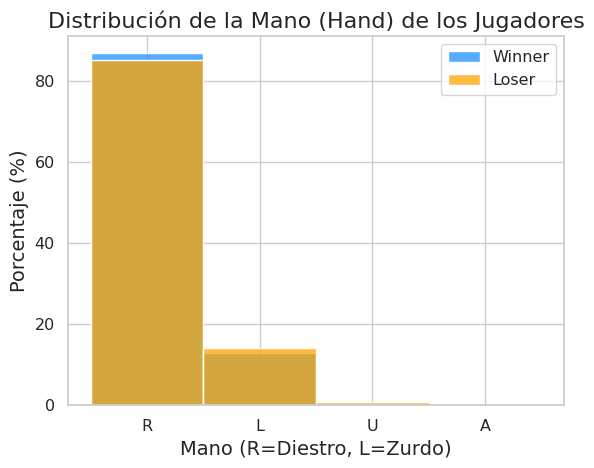

In [24]:
# --- B.3.2 SOLUCIÓN QUIRÚRGICA PARA LA MANO (HAND) ---

# 1. CORRECCIÓN MANUAL DE LOS NANS (Datos investigados)
# Diccionario con los datos reales que hemos encontrado
manos_rescatadas = {
    'Nour Nehme': 'R',
    'Maxim Bulat': 'R',
    'Sebastian Dominguez': 'R'
}

print("Aplicando correcciones manuales a los NaNs...")
for nombre, mano in manos_rescatadas.items():
    # Corregimos tanto en winner como en loser por si acaso
    tennis.loc[tennis['winner_name'] == nombre, 'winner_hand'] = mano
    tennis.loc[tennis['loser_name'] == nombre, 'loser_hand'] = mano

# Verificamos si queda algún NaN real (debería ser 0)
nulos_reales = tennis['winner_hand'].isna().sum() + tennis['loser_hand'].isna().sum()
print(f"Nulos reales (NaN) restantes: {nulos_reales}")


# 2. TRATAMIENTO DE LOS 'U' (Unknown)
# Ahora nos ocupamos de los 273 casos etiquetados como 'U'.
# Al no existir registro oficial de su mano, la opción más segura para el modelo
# es asignarlos a la clase mayoritaria (Diestro/Right), que representa el ~90% de los jugadores.

#print(f"Tratando las etiquetas 'U'...")
#tennis['winner_hand'] = tennis['winner_hand'].replace('U', 'R')
#tennis['loser_hand'] = tennis['loser_hand'].replace('U', 'R')

# 3. VERIFICACIÓN FINAL
# Ahora solo deberíamos tener 'R' y 'L' (y quizás 'A' si había alguno)
print("\n--- Estado Final de la Variable Hand ---")
print(f"Valores únicos: {tennis['loser_hand'].unique()}")
print(f"Total Nulos: {tennis[['winner_hand', 'loser_hand']].isna().sum().sum()}")

sns.histplot(tennis['winner_hand'], color='dodgerblue', label='Winner', kde=False, stat='percent', discrete=True)
sns.histplot(tennis['loser_hand'], color='orange', label='Loser', kde=False, stat='percent', discrete=True)
plt.title("Distribución de la Mano (Hand) de los Jugadores", fontsize=16)
plt.xlabel("Mano (R=Diestro, L=Zurdo)", fontsize=14)
plt.ylabel("Porcentaje (%)", fontsize=14)
plt.legend()
plt.show()

mirar pero hay que tratar U

De momento, por simplificar, las unkownn las pasaremos a derecho.

In [25]:
# --- B.3.2 SIMPLIFICACIÓN DE LA MANO (HAND) ---

# Reemplazamos tanto 'U' (Unknown) como los NaN por 'R' (Right/Diestro)
# Esto elimina el sesgo de la categoría 'U' (que el modelo asociaba a perder).
tennis['winner_hand'] = tennis['winner_hand'].replace('U', 'R').fillna('R')
tennis['loser_hand'] = tennis['loser_hand'].replace('U', 'R').fillna('R')

# --- VERIFICACIÓN ---
print("Corrección aplicada. Valores únicos actuales:")
print(f"Winner Hand: {tennis['winner_hand'].unique()}")
print(f"Loser Hand: {tennis['loser_hand'].unique()}")

Corrección aplicada. Valores únicos actuales:
Winner Hand: ['R' 'L' 'A']
Loser Hand: ['R' 'L']


vemos que hay casos de jugadores ambidiestrso, al haber tan pocos casos los consideraremos R.

In [26]:
tennis['winner_hand'] = tennis['winner_hand'].replace('A').fillna('R')
print(f"Winner Hand: {tennis['winner_hand'].unique()}")

Winner Hand: ['R' 'L']


---

### B.3-Paso 4. Seeds y entries.

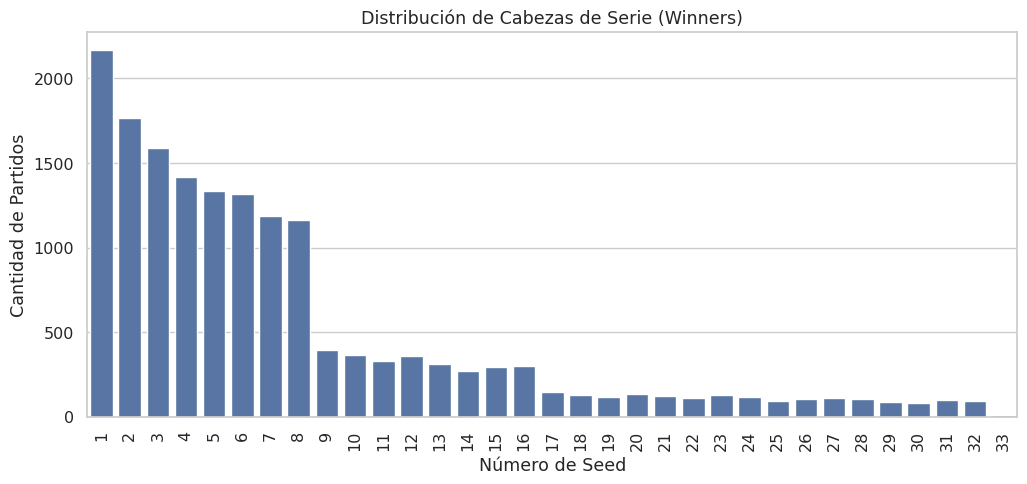

Seed máximo encontrado: 33.0


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convertimos a numérico por si acaso hay texto mezclado, forzando errores a NaN
tennis['winner_seed'] = pd.to_numeric(tennis['winner_seed'], errors='coerce')

# Gráfico de distribución de Seeds
plt.figure(figsize=(12, 5))
sns.countplot(x=tennis['winner_seed'].dropna().astype(int))
plt.title('Distribución de Cabezas de Serie (Winners)')
plt.xlabel('Número de Seed')
plt.ylabel('Cantidad de Partidos')
plt.xticks(rotation=90) # Rotar etiquetas si hay muchas
plt.show()

print(f"Seed máximo encontrado: {tennis['winner_seed'].max()}")

In [28]:
# --- TRATAMIENTO DE SEEDS Y ENTRIES ---

# 1. SEEDS: Usamos 100 para indicar "Peor que el último seed (32)"
# Si usáramos -1, el modelo pensaría que son mejores que el nº1.
val_no_seed = 100

tennis['winner_seed'] = tennis['winner_seed'].fillna(val_no_seed)
tennis['loser_seed'] = tennis['loser_seed'].fillna(val_no_seed)

# 2. ENTRIES: Los nulos son 'Direct Acceptance' (Entrada directa por ranking)
tennis['winner_entry'] = tennis['winner_entry'].fillna('DA')
tennis['loser_entry'] = tennis['loser_entry'].fillna('DA')

# Verificación
print("Imputación realizada.")
print(f"Nulos restantes en Seeds: {tennis['winner_seed'].isna().sum()}")
print(f"Nulos restantes en Entries: {tennis['winner_entry'].isna().sum()}")
print(f"Valores únicos en Entry: {tennis['winner_entry'].unique()}")

Imputación realizada.
Nulos restantes en Seeds: 0
Nulos restantes en Entries: 0
Valores únicos en Entry: ['DA' 'Q' 'WC' 'LL' 'PR' 'SE' 'ALT' 'Alt' 'ITF' 'UP' 'W']


In [29]:
# --- ESTANDARIZACIÓN Y CORRECCIÓN DE ENTRIES ---

# 1. Limpieza básica: Mayúsculas y quitar espacios (Arregla 'Alt' vs 'ALT')
tennis['winner_entry'] = tennis['winner_entry'].str.upper().str.strip()
tennis['loser_entry'] = tennis['loser_entry'].str.upper().str.strip()

# 2. Corrección de errores tipográficos específicos
# Diccionario de reemplazos: 'W' se convierte en 'WC'
correcciones = {'W': 'WC'}

tennis['winner_entry'] = tennis['winner_entry'].replace(correcciones)
tennis['loser_entry'] = tennis['loser_entry'].replace(correcciones)

# --- VERIFICACIÓN ---
print("Correcciones aplicadas: Mayúsculas + Unificación W->WC.")
print(f"Valores únicos en Winner Entry: {tennis['winner_entry'].unique()}")
print(f"Valores únicos en Loser Entry:  {tennis['loser_entry'].unique()}")

Correcciones aplicadas: Mayúsculas + Unificación W->WC.
Valores únicos en Winner Entry: ['DA' 'Q' 'WC' 'LL' 'PR' 'SE' 'ALT' 'ITF' 'UP']
Valores únicos en Loser Entry:  ['Q' 'DA' 'WC' 'LL' 'PR' 'SE' 'ALT' 'ITF' 'UP']


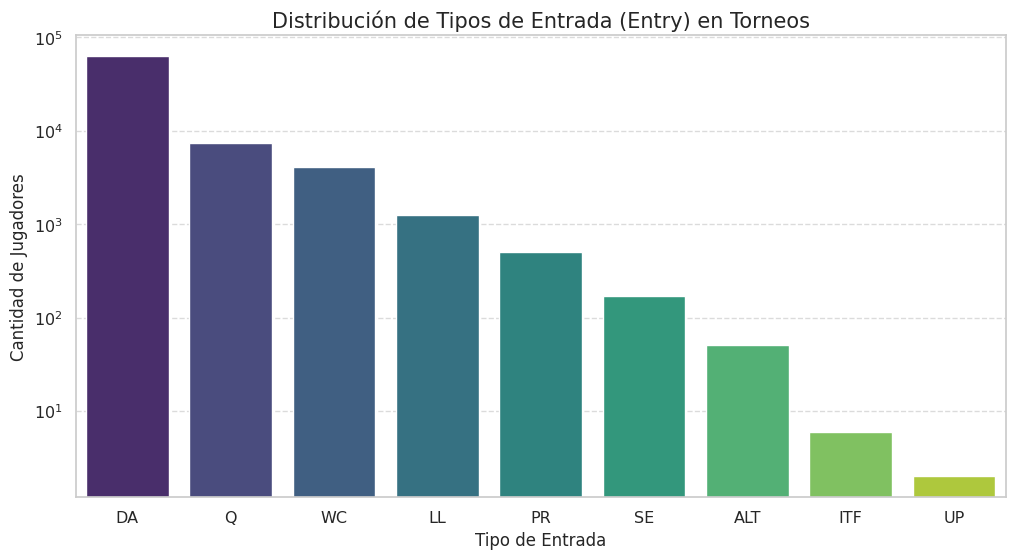

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Unimos ganadores y perdedores para ver la distribución global del circuito
todas_las_entradas = pd.concat([tennis['winner_entry'], tennis['loser_entry']])

plt.figure(figsize=(12, 6))

# Countplot con orden descendente
sns.countplot(x=todas_las_entradas, order=todas_las_entradas.value_counts().index, palette='viridis')

# Estética
plt.title('Distribución de Tipos de Entrada (Entry) en Torneos', fontsize=15)
plt.xlabel('Tipo de Entrada', fontsize=12)
plt.ylabel('Cantidad de Jugadores', fontsize=12)
plt.yscale('log') # ESCALA LOGARÍTMICA: Truco clave
                  # Como 'DA' es gigante comparado con el resto, usamos logaritmo 
                  # para poder ver las barras pequeñas (WC, Q, LL) sin que desaparezcan.

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


* **DA:** Direct Acceptance (Ranking directo).
* **Q:** Qualifier (Viene de la fase previa).
* **WC:** Wild Card (Invitado).
* **LL:** Lucky Loser (Perdió la previa pero entró por baja de otro).
* **PR:** Protected Ranking (Vuelve de lesión con ranking congelado).
* **SE:** Special Exempt.
* **ALT:** Alternate (Suplente).
* **ITF:** International Tennis Federation (invited by them).
* **UP:** Unranked player.


---

### B.3-Paso 5. Rankings y puntos.

In [31]:
# --- B.3.3 TRATAMIENTO DE RANKINGS Y PUNTOS ---

# 1. Definimos el valor para "Sin Ranking"
# Usamos 3000 porque es peor que cualquier ranking profesional normal (aprox 2000).
rank_bajo = 3000

# 2. Imputamos Rankings
tennis['winner_rank'] = tennis['winner_rank'].fillna(rank_bajo)
tennis['loser_rank'] = tennis['loser_rank'].fillna(rank_bajo)

# 3. Imputamos Puntos (Si no hay ranking, hay 0 puntos)
tennis['winner_rank_points'] = tennis['winner_rank_points'].fillna(0)
tennis['loser_rank_points'] = tennis['loser_rank_points'].fillna(0)

# --- VERIFICACIÓN ---
print("Rankings y Puntos imputados.")
print(f"Nulos restantes en Rank (W/L): {tennis['winner_rank'].isna().sum()} / {tennis['loser_rank'].isna().sum()}")
print(f"Nulos restantes en Points (W/L): {tennis['winner_rank_points'].isna().sum()} / {tennis['loser_rank_points'].isna().sum()}")

Rankings y Puntos imputados.
Nulos restantes en Rank (W/L): 0 / 0
Nulos restantes en Points (W/L): 0 / 0


---

### B.3-Paso 6. Alturas.

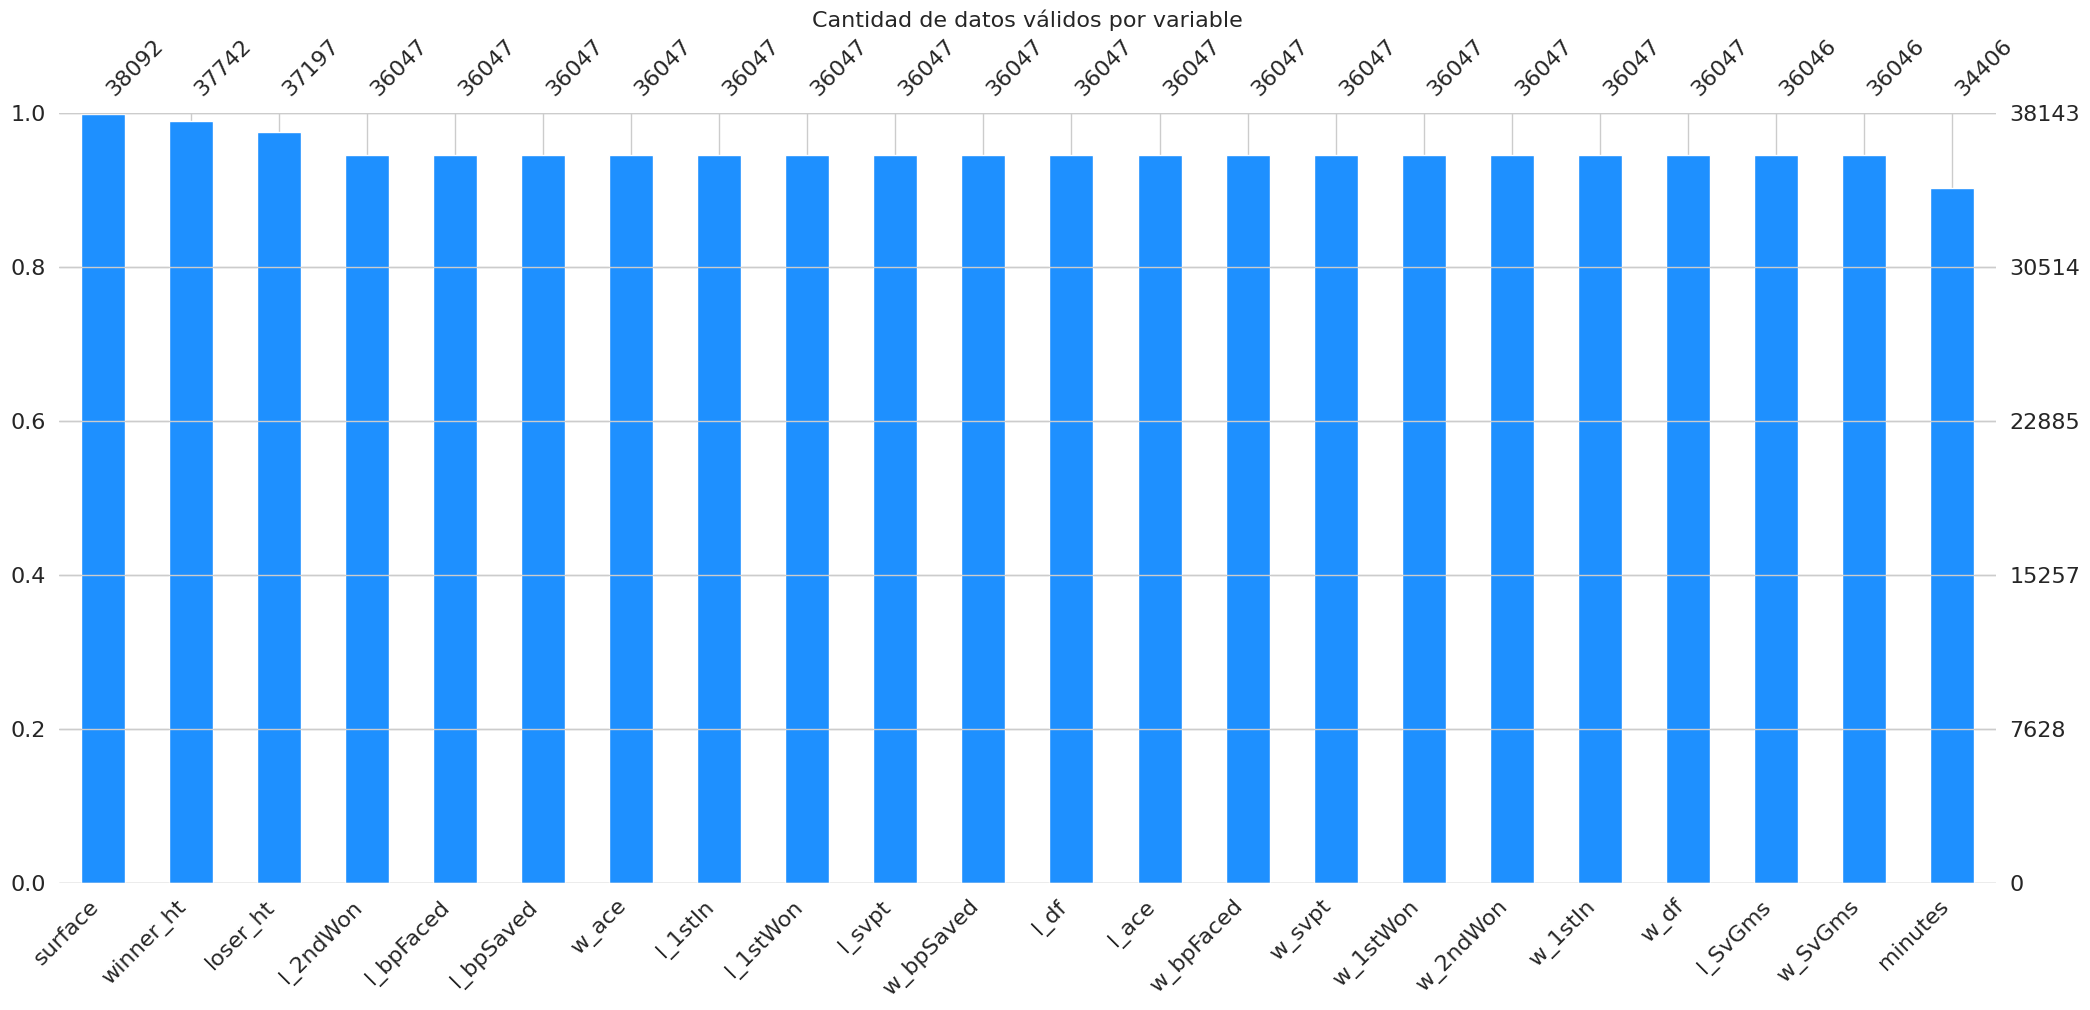

In [32]:
import missingno as msno
import matplotlib.pyplot as plt

# 1. Identificar las columnas que tienen nulos
cols_con_nulos = tennis.columns[tennis.isna().any()].tolist()

# Gráfico de barras de las variables con nulos
msno.bar(tennis[cols_con_nulos], sort='descending', color='dodgerblue')
plt.title("Cantidad de datos válidos por variable", fontsize=16)
plt.show()

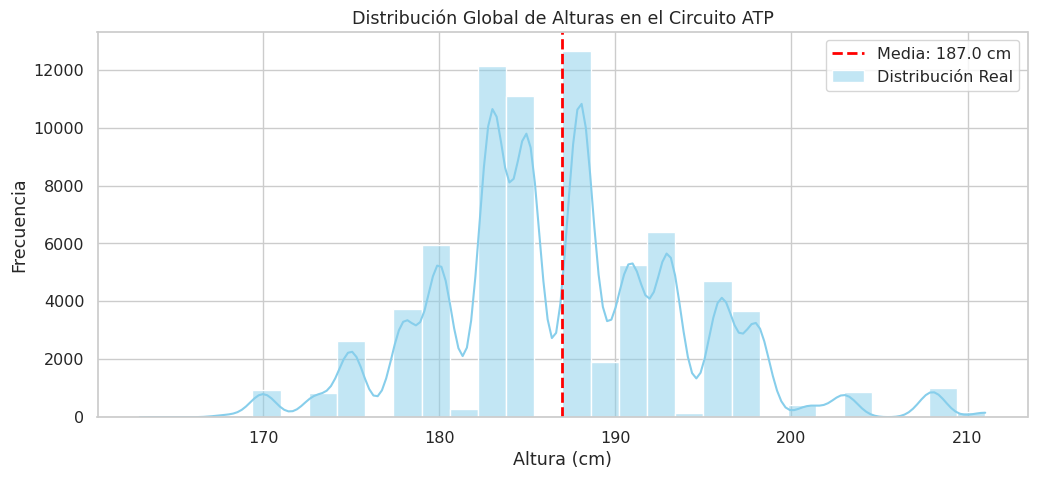

--- ANÁLISIS DE VALORES FALTANTES ---
Ranking promedio de jugadores CON altura conocida: 77
Ranking promedio de jugadores SIN altura (Nulos): 1502


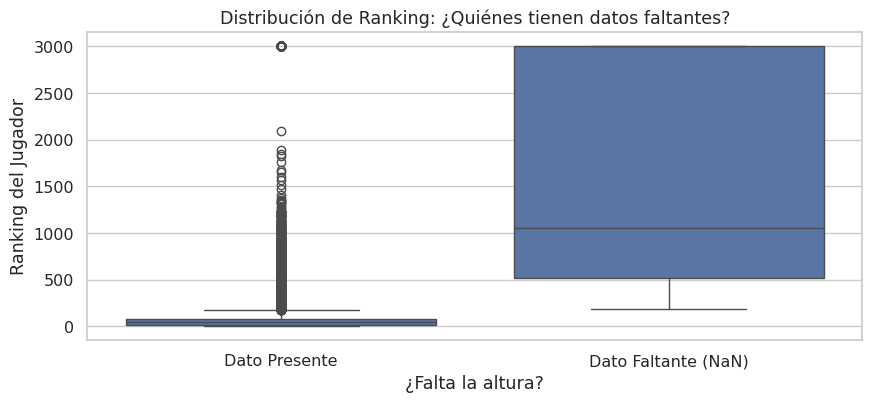

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- 1. VISUALIZACIÓN DE LA DISTRIBUCIÓN (Winner + Loser) ---
# Unimos ganadores y perdedores para ver la "población total" de tenistas
all_heights = pd.concat([tennis['winner_ht'], tennis['loser_ht']])
mean_height = all_heights.mean()

plt.figure(figsize=(12, 5))

# Histograma y densidad
sns.histplot(all_heights, kde=True, bins=30, color='skyblue', label='Distribución Real')
# Línea de la media
plt.axvline(mean_height, color='red', linestyle='--', linewidth=2, label=f'Media: {mean_height:.1f} cm')

plt.title('Distribución Global de Alturas en el Circuito ATP')
plt.xlabel('Altura (cm)')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

# --- 2. ¿POR QUÉ FALTAN DATOS? (Análisis de Missing Values) ---
# Hipótesis: Faltan datos en jugadores de RANKING BAJO (Desconocidos)

# Creamos una columna temporal para identificar si falta la altura
# Usamos winner para el ejemplo, pero aplica a ambos
tennis['missing_ht_w'] = tennis['winner_ht'].isna()

# Calculamos el ranking promedio de los que TIENEN altura vs los que NO
rank_con_dato = tennis[tennis['missing_ht_w'] == False]['winner_rank'].mean()
rank_sin_dato = tennis[tennis['missing_ht_w'] == True]['winner_rank'].mean()

print("--- ANÁLISIS DE VALORES FALTANTES ---")
print(f"Ranking promedio de jugadores CON altura conocida: {rank_con_dato:.0f}")
print(f"Ranking promedio de jugadores SIN altura (Nulos): {rank_sin_dato:.0f}")

# Visualización por Ranking
plt.figure(figsize=(10, 4))
sns.boxplot(x='missing_ht_w', y='winner_rank', data=tennis)
plt.title('Distribución de Ranking: ¿Quiénes tienen datos faltantes?')
plt.xlabel('¿Falta la altura?')
plt.ylabel('Ranking del Jugador')
plt.xticks([0, 1], ['Dato Presente', 'Dato Faltante (NaN)'])
plt.show()

# Limpieza auxiliar
tennis.drop(columns=['missing_ht_w'], inplace=True)

In [34]:
# --- DETECTIVE DE ALTURAS FALTANTES ---

# 1. Buscamos nombres en la columna Winner donde la altura sea NaN
w_sin_altura = tennis[tennis['winner_ht'].isna()]['winner_name']

# 2. Buscamos nombres en la columna Loser donde la altura sea NaN
l_sin_altura = tennis[tennis['loser_ht'].isna()]['loser_name']

# 3. Juntamos ambas listas y nos quedamos solo con los nombres ÚNICOS
# (Porque un jugador puede haber jugado 5 partidos y salir 5 veces)
jugadores_sin_altura = pd.concat([w_sin_altura, l_sin_altura]).unique()
jugadores_sin_altura.sort() # Los ordenamos alfabéticamente para verlos mejor

# --- RESULTADOS ---
print(f"Número total de jugadores únicos sin altura: {len(jugadores_sin_altura)}")
print("\nLista de jugadores:")
print(jugadores_sin_altura)

Número total de jugadores únicos sin altura: 440

Lista de jugadores:
['Abdulhameed Alshatti' 'Abdulhamid Mubarak' 'Abdullah Maqdas'
 'Abdulrahman Alawadhi' 'Adam Hornby' 'Adam Kellner'
 'Aditya Hari Sasongko' 'Adrien Bossel' 'Ainius Sabaliauskas'
 'Aissa Benchakroun' 'Alberto Emmanuel Alvarado Larin' 'Alberto Lim'
 'Alen Avidzba' 'Alex Diaz' 'Alex Fairbanks' 'Alex Llompart'
 'Alexander Blom' 'Alexandros Jakupovic' 'Alexios Halebian'
 'Alexis Klegou' 'Ali Ghareeb' 'Amer Naow' 'Amir Hossein Badi'
 'Amir Milushev' 'Anas Fattar' 'Andis Juska' 'Ando Rasolomalala'
 'Andre Gaspar Murta' 'Andrea Basso' 'Andreas Bjerrehus' 'Andrei Ciumac'
 'Andrei Daescu' 'Andrei Gorban' 'Andrei Soltoianu'
 'Andres Artunedo Martinavarro' 'Andres Bucaro' 'Andres Weisskopf'
 'Andrey Kumantsov' 'Anil Yuksel' 'Anis Ghorbel' 'Anoosha Shahgholi'
 'Anthony Jackie Tang' 'Anthony Marshall' 'Anthony Susanto'
 'Antso Rakotondramanga' 'Aqeel Khan' 'Ari Fahresi'
 'Ariez Elyaas Deen Heshaam' 'Aristotelis Thanos' 'Arturs Laz

In [35]:
import numpy as np

# --- B.3.4 SOLUCIÓN AVANZADA: IMPUTACIÓN ALEATORIA (Probabilística) ---

# 1. Analizamos la distribución actual (de los datos que SÍ tenemos)
todos_con_altura = pd.concat([tennis['winner_ht'].dropna(), tennis['loser_ht'].dropna()])
media = todos_con_altura.mean()
std = todos_con_altura.std() # Desviación típica (cuánto varían las alturas)

print(f"Parámetros de la distribución real -> Media: {media:.2f} cm | Desviación: {std:.2f} cm")

# 2. Función para rellenar huecos generando datos que parezcan reales
def imputar_aleatorio(columna, mu, sigma):
    # Contamos cuántos huecos hay
    n_nulos = columna.isna().sum()
    if n_nulos > 0:
        # Generamos n números aleatorios siguiendo la distribución Normal(media, desviación)
        valores_generados = np.random.normal(loc=mu, scale=sigma, size=n_nulos)
        
        # Opcional: Redondear a enteros o 1 decimal para que parezca dato real
        valores_generados = np.round(valores_generados, 0)
        
        # Rellenamos solo los huecos
        columna_rellena = columna.copy()
        columna_rellena.loc[columna.isna()] = valores_generados
        return columna_rellena
    else:
        return columna

# 3. Aplicamos la magia
# Usamos una semilla (seed) para que sea reproducible (que siempre salga lo mismo si repites)
np.random.seed(42) 

tennis['winner_ht'] = imputar_aleatorio(tennis['winner_ht'], media, std)
tennis['loser_ht'] = imputar_aleatorio(tennis['loser_ht'], media, std)

print("Alturas imputadas siguiendo la distribución estadística original (sin picos artificiales).")

# 4. Tratamiento de MINUTOS (Aquí sí usamos la media simple, el tiempo es menos crítico)
media_minutos = tennis['minutes'].mean()
tennis['minutes'] = tennis['minutes'].fillna(media_minutos)
print(f"Minutos imputados con la media ({media_minutos:.1f} min).")

# --- VERIFICACIÓN FINAL ---
nulos_finales = tennis[['winner_ht', 'loser_ht', 'minutes']].isna().sum().sum()
print(f"\nNulos restantes en Físicas/Tiempo: {nulos_finales} (Debe ser 0)")

Parámetros de la distribución real -> Media: 186.99 cm | Desviación: 7.05 cm
Alturas imputadas siguiendo la distribución estadística original (sin picos artificiales).
Minutos imputados con la media (112.5 min).

Nulos restantes en Físicas/Tiempo: 0 (Debe ser 0)


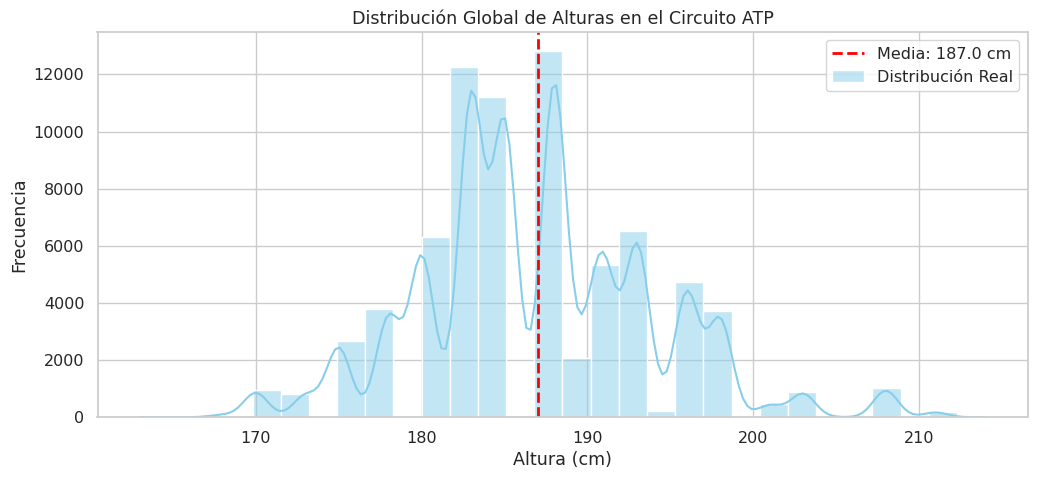

In [36]:
# --- 1. VISUALIZACIÓN DE LA DISTRIBUCIÓN (Winner + Loser) ---
# Unimos ganadores y perdedores para ver la "población total" de tenistas
all_heights = pd.concat([tennis['winner_ht'], tennis['loser_ht']])
mean_height = all_heights.mean()

plt.figure(figsize=(12, 5))

# Histograma y densidad
sns.histplot(all_heights, kde=True, bins=30, color='skyblue', label='Distribución Real')
# Línea de la media
plt.axvline(mean_height, color='red', linestyle='--', linewidth=2, label=f'Media: {mean_height:.1f} cm')

plt.title('Distribución Global de Alturas en el Circuito ATP')
plt.xlabel('Altura (cm)')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

---

### B.3-Paso 7. Surfaces y aces.

In [37]:
# --- B.3.5 LIMPIEZA FINAL (Eliminación de filas irrecuperables) ---

# 1. SUPERFICIE
# Eliminamos los partidos donde no sabemos si es Clay, Hard o Grass.
# Son muy pocos (aprox. 50), así que no duele.
tennis.dropna(subset=['surface'], inplace=True)

# 2. ESTADÍSTICAS DE JUEGO (MATCH STATS)
# Eliminamos los partidos que no tienen registro de puntos (Aces, Break Points, etc.).
# Usamos 'w_ace' como referencia; si falta este, faltan todos.
tennis.dropna(subset=['w_ace'], inplace=True)

# Reiniciamos el índice para que quede ordenado del 0 al final
tennis.reset_index(drop=True, inplace=True)

# --- VERIFICACIÓN DEFINITIVA ---
print(f"Filas finales en el dataset: {len(tennis)}")

# Comprobación de Nulos Totales (El momento de la verdad)
total_nulos = tennis.isna().sum().sum()

if total_nulos == 0:
    print("\n✅ ¡ENHORABUENA! EL DATASET ESTÁ COMPLETAMENTE LIMPIO (0 NULOS).")
    print("Estás listo para el Paso 4: Tratamiento de Outliers.")
else:
    print(f"\n⚠️ Aún quedan {total_nulos} nulos. Ejecuta el siguiente comando para ver dónde:")
    print("tennis.isna().sum()[tennis.isna().sum() > 0]")

Filas finales en el dataset: 36047

⚠️ Aún quedan 2 nulos. Ejecuta el siguiente comando para ver dónde:
tennis.isna().sum()[tennis.isna().sum() > 0]


In [38]:
tennis.isna().sum()[tennis.isna().sum() > 0]

w_SvGms    1
l_SvGms    1
dtype: int64

In [39]:
# --- B.3.6 ELIMINACIÓN QUIRÚRGICA FINAL (El último superviviente) ---

# 1. Inspeccionar quién es el partido problemático
fila_problem = tennis[tennis['w_SvGms'].isna() | tennis['l_SvGms'].isna()]

print("--- El partido rebelde es: ---")
if len(fila_problem) > 0:
    # Mostramos fecha, jugadores y score para identificarlo
    display(fila_problem[['tourney_date', 'winner_name', 'loser_name', 'score', 'w_SvGms', 'l_SvGms']])

# 2. Eliminar esa fila específica
tennis.dropna(subset=['w_SvGms', 'l_SvGms'], inplace=True)
tennis.reset_index(drop=True, inplace=True)

# 3. VERIFICACIÓN FINAL (Ahora sí que sí)
nulos_finales = tennis.isna().sum().sum()
print(f"\nFilas restantes: {len(tennis)}")
print(f"Nulos totales: {nulos_finales}")

if nulos_finales == 0:
    print("\n🎉 ¡OBJETIVO CUMPLIDO! DATASET INMACULADO. 🎉")

--- El partido rebelde es: ---


,tourney_date,winner_name,loser_name,score,w_SvGms,l_SvGms
35139,2024-07-29,Casper Ruud,Francisco Cerundolo,6-3 6-4,NaN,NaN



Filas restantes: 36046
Nulos totales: 0

🎉 ¡OBJETIVO CUMPLIDO! DATASET INMACULADO. 🎉


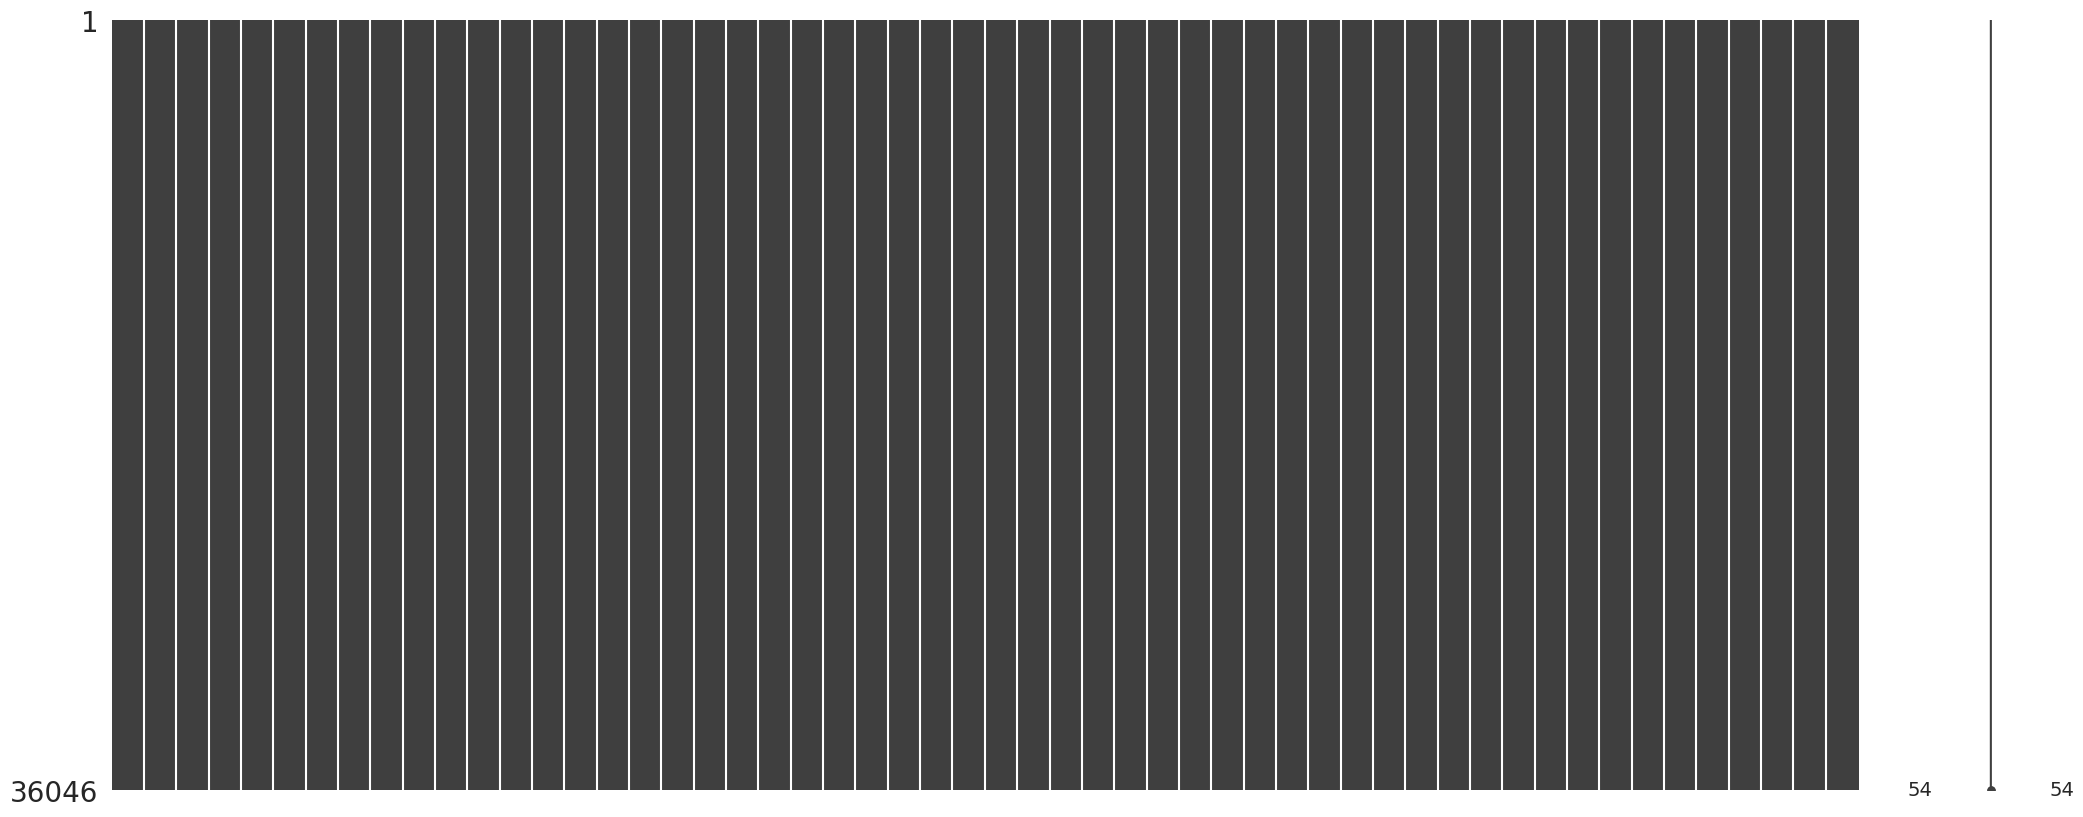

In [40]:
msno.matrix(tennis);

---
---

## B.4-Tratamiento de outliers


---
---

## B.5-Crear nuevas variables que pueden ser interesantes (Feature engineering)

Este apartado es, bajo nuestro rigor, el más importante de la práctica, es el apartado que nos permite obtener unas mejoras features para darle más información al modelo y poder tener mejores modelos, con mejores puntuaciones.

Vamos a ver primero todas las features que tenemos actualmente.



In [41]:
tennis.shape

(36046, 54)

In [42]:
tennis.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points',
       'year', 'month', 'day', 'month_name', 'tourney_points'],
      dtype='object')>

## B.5.1-H2H

In [43]:
def agregar_h2h(df_original):
    """
    Calcula el historial de enfrentamientos previos (H2H) sin deformar el dataframe.
    """
    print("Calculando Head-to-Head (H2H)... 🥊")
    
    # 1. Hacemos una COPIA ligera o nos aseguramos de no romper el orden
    # Es CRÍTICO que esté ordenado por fecha para no viajar al futuro
    df = df_original.sort_values(['tourney_date', 'match_num']).copy()
    
    # 2. ESTRUCTURA AUXILIAR (La "Libreta")
    # Clave: Tupla (ganador_id, perdedor_id) -> Valor: Número de victorias
    wins_registry = {}
    
    # Listas temporales para guardar los datos que luego pegaremos
    w_h2h_past = [] # Victorias previas del Winner sobre este Loser
    l_h2h_past = [] # Victorias previas del Loser sobre este Winner
    
    # 3. ITERACIÓN (La lógica temporal)
    # Usamos las columnas numpy para ir MUCHO más rápido que .iterrows()
    winner_ids = df['winner_id'].values
    loser_ids = df['loser_id'].values
    
    for w_id, l_id in zip(winner_ids, loser_ids):
        
        # A. CONSULTAR EL PASADO (Auxiliar)
        # ¿Cuántas veces ha ganado ya el W al L?
        # .get((clave), 0) devuelve 0 si nunca se han enfrentado
        prior_wins_w = wins_registry.get((w_id, l_id), 0)
        
        # ¿Cuántas veces ha ganado ya el L al W?
        prior_wins_l = wins_registry.get((l_id, w_id), 0)
        
        # Guardamos lo que sabíamos ANTES del partido
        w_h2h_past.append(prior_wins_w)
        l_h2h_past.append(prior_wins_l)
        
        # B. ACTUALIZAR EL AUXILIAR (Para el futuro)
        # Ahora el winner suma una victoria más sobre este loser específico
        wins_registry[(w_id, l_id)] = prior_wins_w + 1
    
    # 4. INYECTAR EN EL DATAFRAME ORIGINAL
    # Solo ahora modificamos el dataframe
    df['w_h2h'] = w_h2h_past
    df['l_h2h'] = l_h2h_past
    
    print("✅ H2H calculado e inyectado.")
    return df

tennis = agregar_h2h(tennis)

Calculando Head-to-Head (H2H)... 🥊
✅ H2H calculado e inyectado.


## B.5.2-¿Es cabeza de serie?


In [44]:
import numpy as np

def agregar_is_seeded(df):
    print("Calculando variable 'is_seeded'... 🌱")
    
    # Simplemente comprobamos si la columna 'seed' tiene algún valor (no es nula)
    # np.where(condición, valor_si_true, valor_si_false)
    
    # Para el Winner
    df['w_is_seeded'] = np.where(df['winner_seed'].notna(), 1, 0)
    
    # Para el Loser
    df['l_is_seeded'] = np.where(df['loser_seed'].notna(), 1, 0)
    
    print("✅ Variable 'is_seeded' agregada.")
    return df

tennis = agregar_is_seeded(tennis)

Calculando variable 'is_seeded'... 🌱
✅ Variable 'is_seeded' agregada.


## B.5.3-¿Es su primer partido registrado?

¡Tienes toda la razón! Ese es el problema clásico del **"Censurado por la Izquierda"** (Left Censoring).

Si tu dataset empieza el `01-01-2011`, para el código **Federer** "nace" ese día. Pero si le pones la etiqueta `is_first_match = 1`, el modelo pensará que es un novato sin experiencia, cuando en realidad es el número 2 del mundo. **Eso confundiría muchísimo al modelo.**

### La Solución: El "Filtro de Veteranos" (Heurística de Ranking) 🎓

¿Cómo distinguimos a un **novato real** (que juega su primer partido ATP) de un **veterano** que simplemente aparece por primera vez en tu archivo?

**La respuesta es el Ranking.**

* Un **Novato Real** suele tener Ranking > 150, Ranking > 200 o directamente no tener Ranking.
* **Federer** en 2011 aparece por primera vez, pero tiene **Ranking 2**.
* Nadie debuta en la ATP siendo número 2 del mundo.

### Estrategia Corregida

Vamos a modificar la función para que `is_first_match` solo sea `1` si:

1. Es la primera vez que aparece en el dataset.
2. **Y ADEMÁS** tiene un ranking malo (ej. > 200) o no tiene ranking.

Si aparece por primera vez pero es Top 100, asumimos que es un **"Veterano sin Historial"** (es decir, sabemos que es bueno por el ranking, pero no tenemos sus stats de aces del año pasado). `is_first_match` será `0`.


### ¿Qué pasa ahora con Federer en 2011?

1. **Su variable `w_is_first_match` será `0`.**
* El modelo dice: *"Ah, este tío no es nuevo. Ya sabe jugar."*


2. **Sus estadísticas históricas (Last 10 aces) serán `NaN` (o imputadas neutras).**
* El modelo dice: *"Sé que es veterano, pero no sé cómo ha jugado últimamente. Me fiaré puramente de su **Ranking** (que sí lo tengo y es 2)."*



Esta es la forma más honesta de tratar el inicio del dataset: respetas su jerarquía (ranking) sin inventar estadísticas que no tienes.


In [45]:
import pandas as pd
import numpy as np

def agregar_indicador_primer_partido_inteligente(df):
    print("Identificando 'True Rookies' vs 'Veteranos Censurados'... 🕵️‍♂️")
    
    # 1. PREPARAR AUXILIAR (Igual que antes)
    df_w = df[['tourney_date', 'match_num', 'winner_id', 'winner_rank']].copy() # Añadimos Rank
    df_w.columns = ['date', 'match_num', 'player_id', 'rank']
    
    df_l = df[['tourney_date', 'match_num', 'loser_id', 'loser_rank']].copy() # Añadimos Rank
    df_l.columns = ['date', 'match_num', 'player_id', 'rank']
    
    df_long = pd.concat([df_w, df_l]).sort_values(['date', 'match_num'])
    
    # 2. CONTADOR DE APARICIONES
    df_long['match_count'] = df_long.groupby('player_id').cumcount()
    
    # 3. LA LÓGICA MAESTRA (HEURÍSTICA DE RANKING)
    # Definimos el umbral: Si tienes ranking mejor que 200, NO eres novato.
    # Federer en 2011 (Rank 2) -> match_count=0 PERO rank=2 -> is_rookie = 0
    RANK_THRESHOLD = 200
    
    # Condición: Es su primer partido EN EL ARCHIVO...
    cond_first_time = (df_long['match_count'] == 0)
    
    # ... Y ADEMÁS tiene ranking bajo (o nulo), lo que confirma que es novato.
    # Si el rank es NaN (común en debuts absolutos), lo tratamos como > 200 (True)
    cond_bad_rank = (df_long['rank'].fillna(9999) > RANK_THRESHOLD)
    
    # Solo es "True Rookie" si cumple ambas
    df_long['is_first_match'] = np.where(cond_first_time & cond_bad_rank, 1, 0)
    
    # Debug: Ver a quién estamos salvando
    veteranos_salvados = df_long[cond_first_time & ~cond_bad_rank]
    print(f"   ℹ️ Detectados {len(veteranos_salvados)} jugadores veteranos al inicio del dataset (ej. Federer, Nadal).")
    print(f"      No serán marcados como novatos.")

    # 4. MERGE (Igual que antes)
    cols_to_merge = ['date', 'match_num', 'player_id', 'is_first_match']
    df_flags = df_long[cols_to_merge]
    
    # Merge Winner
    df = df.merge(df_flags, 
                  left_on=['tourney_date', 'match_num', 'winner_id'], 
                  right_on=['date', 'match_num', 'player_id'], how='left')
    df.rename(columns={'is_first_match': 'w_is_first_match'}, inplace=True)
    df.drop(columns=['date', 'player_id'], inplace=True)
    
    # Merge Loser
    df = df.merge(df_flags, 
                  left_on=['tourney_date', 'match_num', 'loser_id'], 
                  right_on=['date', 'match_num', 'player_id'], how='left')
    df.rename(columns={'is_first_match': 'l_is_first_match'}, inplace=True)
    df.drop(columns=['date', 'player_id'], inplace=True)
    
    print(f"✅ Variable 'is_first_match' creada (con filtro de veteranos).")
    return df

# Ejecutar
tennis = agregar_indicador_primer_partido_inteligente(tennis)

Identificando 'True Rookies' vs 'Veteranos Censurados'... 🕵️‍♂️
   ℹ️ Detectados 281 jugadores veteranos al inicio del dataset (ej. Federer, Nadal).
      No serán marcados como novatos.
✅ Variable 'is_first_match' creada (con filtro de veteranos).


### B.5.4-Forma de los últimos partidos

1. 1 último partido
2. 5 últimos partidos
3. 10 últimos partidos
4. últimos 12 meses
5. toda la vida


### RESUMEN 

#### 1. Las 7 Variables de Forma (The Magnificent Seven)

Calculadas para cada una de las 5 ventanas (`last_1`, `last_5`, `last_10`, `last_52w`, `lifetime`).

| Categoría | Variable | Fórmula Técnica | Qué mide |
| --- | --- | --- | --- |
| **Clase** | `win_rate` | `Won / Matches` | Nivel general |
| **Potencia** | `ace_pct` | `Aces / Svpt` | Daño al servicio |
| **Control** | `df_pct` | `DF / Svpt` | Estabilidad mental |
| **Eficacia** | `1st_won_pct` | `1stWon / 1stIn` | Dominio de fondo |
| **Defensa** | `bp_save_pct` | `BPSaved / BPFaced` | Resistencia bajo presión |
| **Estilo** | `tb_rate` | `TotalTB / TotalSets` | Tendencia a sets cerrados |
| **Clutch** | `tb_won_pct` | `TBWon / TotalTB` | Sangre fría en momentos clave |

---

#### 2. La Lógica de Tratamiento "En Cascada" 🌊

Aplicaremos esto **fila a fila** para generar el input final del modelo (`diff_variable`).

**CASO A: EL ROOKIE ABSOLUTO (Mirroring 🪞)**

* **Condición:** Es su 1er partido (`is_rookie=1`).
* **Valor:** Copiamos el dato de su rival.
* **Diferencia Final:** **0**. (Asumimos igualdad total por desconocimiento).

**CASO B: POCOS DATOS (1-9 Partidos) - (Smoothing 📉)**

* **Condición:** Tiene historial, pero < 10 partidos.
* **Valor:** Aplicamos **Suavizado Bayesiano**.
* Acercamos su dato a la Media Global.
* *Ejemplo:* Si ganó 1 tiebreak de 1 (100%), lo bajamos a un 60%.


* **Diferencia Final:** `Suavizado_P1 - Suavizado_P2`.

**CASO C: VETERANO (10+ Partidos) - (Real ✅)**

* **Condición:** Tiene >= 10 partidos.
* **Valor:** Su dato real.
* **Diferencia Final:** `Real_P1 - Real_P2`.

---





In [46]:
import pandas as pd
import numpy as np
import re

# ==========================================
# PASO 1: PARSING (Crear variables de marcador)
# ==========================================
def parse_match_stats(df):
    print("1. Parsing de marcadores (Sets y Tiebreaks)... 🎾")
    
    # Pre-compilar regex para velocidad (busca patrones "6-4")
    regex_sets = re.compile(r'\d+-\d+')
    
    def analyze_score(score):
        # Si es nulo o string vacío
        if not isinstance(score, str) or score == 'W/O' or pd.isna(score):
            return 0, 0, 0, 0 # n_sets, total_tb, w_tb, l_tb
            
        # 1. Contar Sets terminados
        n_sets = len(regex_sets.findall(score))
        
        # 2. Contar Tiebreaks (Paréntesis abiertos)
        total_tb = score.count('(')
        
        if total_tb == 0:
            return n_sets, 0, 0, 0
            
        # 3. ¿Quién ganó los TB?
        w_tb_won = score.count('7-6')
        l_tb_won = score.count('6-7')
        
        return n_sets, total_tb, w_tb_won, l_tb_won

    # Aplicamos la lógica fila a fila
    stats = [analyze_score(s) for s in df['score']]
    
    # Creamos las columnas que te faltaban
    df['n_sets'] = [x[0] for x in stats]
    df['total_tb'] = [x[1] for x in stats]
    df['w_tb_won'] = [x[2] for x in stats]
    df['l_tb_won'] = [x[3] for x in stats]
    
    print("   -> Variables de Score creadas correctamente.")
    return df

# ==========================================
# PASO 2: CÁLCULO DE FEATURES (Tu función anterior)
# ==========================================
def calcular_features_bayes_raw(df):
    n_inicial = df.shape[1]
    print(f"2. Calculando Métricas Históricas (Bayes)... (Variables iniciales: {n_inicial})")
    
    df['tourney_date'] = pd.to_datetime(df['tourney_date'])
    
    # Configuración de métricas
    metrics_map = {
        'win_rate':    ('n_won', 'd_matches'),
        'ace_pct':     ('n_aces', 'd_svpt'),
        'df_pct':      ('n_df', 'd_svpt'),
        '1st_won_pct': ('n_1stWon', 'd_1stIn'),
        'bp_save_pct': ('n_bpSaved', 'd_bpFaced'),
        'tb_rate':     ('n_total_tb', 'd_sets'),
        'tb_won_pct':  ('n_tb_won', 'd_tb_count')
    }
    
    # Ventanas (puedes quitar '1' o '5' si quieres menos variables)
    windows = [1, 5, 10] 
    
    # Preparar Datos (Formato Largo)
    base_cols_w = ['tourney_date', 'match_num', 'winner_id', 'winner_rank', 
                   'w_ace', 'w_svpt', 'w_df', 'w_1stWon', 'w_1stIn', 'w_bpSaved', 'w_bpFaced',
                   'n_sets', 'total_tb', 'w_tb_won'] # <--- AHORA SÍ EXISTEN ESTAS
                   
    base_cols_l = ['tourney_date', 'match_num', 'loser_id', 'loser_rank', 
                   'l_ace', 'l_svpt', 'l_df', 'l_1stWon', 'l_1stIn', 'l_bpSaved', 'l_bpFaced',
                   'n_sets', 'total_tb', 'l_tb_won']

    df_w = df[base_cols_w].copy()
    df_w.columns = ['date', 'match_num', 'player_id', 'rank', 
                    'n_aces', 'd_svpt', 'n_df', 'n_1stWon', 'd_1stIn', 'n_bpSaved', 'd_bpFaced',
                    'd_sets', 'n_total_tb', 'n_tb_won']
    df_w['d_matches'] = 1; df_w['n_won'] = 1; df_w['d_tb_count'] = df_w['n_total_tb']

    df_l = df[base_cols_l].copy()
    df_l.columns = ['date', 'match_num', 'player_id', 'rank', 
                    'n_aces', 'd_svpt', 'n_df', 'n_1stWon', 'd_1stIn', 'n_bpSaved', 'd_bpFaced',
                    'd_sets', 'n_total_tb', 'n_tb_won']
    df_l['d_matches'] = 1; df_l['n_won'] = 0; df_l['d_tb_count'] = df_l['n_total_tb']

    df_long = pd.concat([df_w, df_l]).sort_values(['player_id', 'date', 'match_num'])
    
    # Rookie Flag
    df_long['cum_matches'] = df_long.groupby('player_id').cumcount()
    df_long['is_rookie'] = np.where((df_long['cum_matches'] == 0) & (df_long['rank'].fillna(999) > 200), 1, 0)

    # Priors Globales
    global_stats = {}
    for name, (num, den) in metrics_map.items():
        total_num = df_long[num].sum()
        total_den = df_long[den].replace(0, np.nan).sum()
        global_stats[name] = total_num / total_den if total_den > 0 else 0

    # Cálculo Bayesiano
    C = 10 
    generated_cols = ['is_rookie']
    
    # A. Ventanas Fijas
    for w in windows:
        suffix = f"_last_{w}"
        for name, (num_col, den_col) in metrics_map.items():
            roll_num = df_long.groupby('player_id')[num_col].transform(lambda x: x.shift(1).rolling(w, min_periods=1).sum()).fillna(0)
            roll_den = df_long.groupby('player_id')[den_col].transform(lambda x: x.shift(1).rolling(w, min_periods=1).sum()).fillna(0)
            matches_played = df_long.groupby('player_id')['d_matches'].transform(lambda x: x.shift(1).rolling(w, min_periods=1).count()).fillna(0)
            
            prior = global_stats[name]
            current_C = np.where(matches_played >= 10, 0, C)
            smoothed = (roll_num + (current_C * prior)) / (roll_den + current_C)
            
            df_long[f"{name}{suffix}"] = smoothed.fillna(prior)
            generated_cols.append(f"{name}{suffix}")

    # B. Lifetime
    for name, (num_col, den_col) in metrics_map.items():
        roll_num = df_long.groupby('player_id')[num_col].transform(lambda x: x.shift(1).expanding().sum()).fillna(0)
        roll_den = df_long.groupby('player_id')[den_col].transform(lambda x: x.shift(1).expanding().sum()).fillna(0)
        matches_played = df_long.groupby('player_id')['d_matches'].transform(lambda x: x.shift(1).expanding().count()).fillna(0)
        
        prior = global_stats[name]
        current_C = np.where(matches_played >= 10, 0, C)
        smoothed = (roll_num + (current_C * prior)) / (roll_den + current_C)
        df_long[f"{name}_lifetime"] = smoothed.fillna(prior)
        generated_cols.append(f"{name}_lifetime")

    # Merge
    print("   -> Fusionando resultados...")
    cols_to_merge = ['date', 'match_num', 'player_id'] + list(set(generated_cols))
    df_stats = df_long[cols_to_merge]
    
    df = df.merge(df_stats, left_on=['tourney_date', 'match_num', 'winner_id'], right_on=['date', 'match_num', 'player_id'], how='left')
    df.rename(columns={c: f"w_{c}" for c in generated_cols}, inplace=True)
    df.drop(columns=['date', 'player_id'], inplace=True)
    
    df = df.merge(df_stats, left_on=['tourney_date', 'match_num', 'loser_id'], right_on=['date', 'match_num', 'player_id'], how='left')
    df.rename(columns={c: f"l_{c}" for c in generated_cols}, inplace=True)
    df.drop(columns=['date', 'player_id'], inplace=True)
    
    print(f"✅ Variables añadidas: {df.shape[1] - n_inicial}. Total: {df.shape[1]}")
    return df

# ==========================================
# EJECUCIÓN SECUENCIAL
# ==========================================

# 1. Primero calculamos n_sets y tb (Parsing)
tennis = parse_match_stats(tennis)

# 2. Ahora sí podemos calcular las features (Ya existen las columnas necesarias)
tennis = calcular_features_bayes_raw(tennis)

1. Parsing de marcadores (Sets y Tiebreaks)... 🎾
   -> Variables de Score creadas correctamente.
2. Calculando Métricas Históricas (Bayes)... (Variables iniciales: 64)
   -> Fusionando resultados...
✅ Variables añadidas: 58. Total: 122


---
---

## B.6-Re-nombrado de las variables

Vamos a cambiar el nombre de winner y loser a player1 y player2 y dividirlo de forma homogenia (50% player1 y 50% player2).

In [47]:
tennis.describe(include="all").T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
tourney_id,36076,1336,2014-540,126,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tourney_name,36076,555,Roland Garros,1723,NaN,NaN,NaN,NaN,NaN,NaN,NaN
surface,36076,4,Hard,20889,NaN,NaN,NaN,NaN,NaN,NaN,NaN
draw_size,36076.0,NaN,NaN,NaN,60.280685,2.0,32.0,32.0,96.0,128.0,41.338364
tourney_level,36076,6,A,20298,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
l_win_rate_last_1,36076.0,NaN,NaN,NaN,0.501526,0.454545,0.454545,0.545455,0.545455,0.545455,0.044872
l_tb_won_pct_last_1,36076.0,NaN,NaN,NaN,0.496423,0.33029,0.495435,0.495435,0.495435,0.611873,0.030551
l_tb_won_pct_lifetime,36076.0,NaN,NaN,NaN,0.486744,0.0,0.43662,0.495435,0.544118,1.0,0.108871
l_ace_pct_last_1,36076.0,NaN,NaN,NaN,0.075766,0.003909,0.038222,0.065449,0.099715,0.529916,0.051758


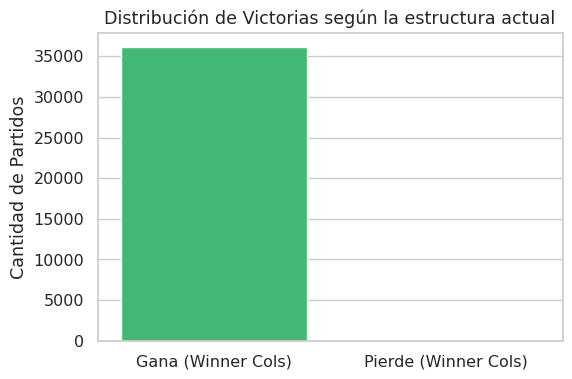

Total de partidos: 36076
Sesgo: El jugador en las columnas 'winner_' gana el 100% de las veces.


In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- VISUALIZACIÓN DEL SESGO ACTUAL ---

# Simulamos lo que ve el modelo actualmente:
# "Si el jugador está en las columnas de la izquierda (Winner), ¿ganó?"
# La respuesta es SI siempre (100%).
frecuencia = [len(tennis), 0]
etiquetas = ['Gana (Winner Cols)', 'Pierde (Winner Cols)']

plt.figure(figsize=(6, 4))
sns.barplot(x=etiquetas, y=frecuencia, palette=['#2ecc71', '#e74c3c'])
plt.title('Distribución de Victorias según la estructura actual')
plt.ylabel('Cantidad de Partidos')
plt.show()

print(f"Total de partidos: {len(tennis)}")
print("Sesgo: El jugador en las columnas 'winner_' gana el 100% de las veces.")

In [49]:
from sklearn.utils import shuffle
import numpy as np

# --- TRANSFORMACIÓN A FORMATO PLAYER 1 / PLAYER 2 ---

# 1. Definir columnas antiguas y nuevas
# Detectamos prefijos automáticamente
cols_w = [c for c in tennis.columns if c.startswith('winner_') or c.startswith('w_')]
cols_l = [c for c in tennis.columns if c.startswith('loser_') or c.startswith('l_')]

# Creamos diccionarios de mapeo
# Caso A: Winner -> P1, Loser -> P2 (Winner = 1)
map_win_p1 = {c: c.replace('winner_', 'p1_').replace('w_', 'p1_') for c in cols_w}
map_los_p2 = {c: c.replace('loser_', 'p2_').replace('l_', 'p2_') for c in cols_l}
map_case_a = {**map_win_p1, **map_los_p2}

# Caso B: Loser -> P1, Winner -> P2 (Winner = 0)
map_los_p1 = {c: c.replace('loser_', 'p1_').replace('l_', 'p1_') for c in cols_l}
map_win_p2 = {c: c.replace('winner_', 'p2_').replace('w_', 'p2_') for c in cols_w}
map_case_b = {**map_los_p1, **map_win_p2}

# 2. Dividir índices aleatoriamente (50% para cada caso)
np.random.seed(42) # Semilla para reproducibilidad
indices = tennis.index.values
idx_a = np.random.choice(indices, size=int(len(indices)/2), replace=False)
idx_b = np.setdiff1d(indices, idx_a)

# 3. Construir los dos dataframes
# Grupo A: P1 es el ganador
df_a = tennis.loc[idx_a].copy()
df_a = df_a.rename(columns=map_case_a)
df_a['Winner'] = 1

# Grupo B: P1 es el perdedor
df_b = tennis.loc[idx_b].copy()
df_b = df_b.rename(columns=map_case_b)
df_b['Winner'] = 0

# 4. Unir y mezclar
tennis_model = pd.concat([df_a, df_b])
tennis_model = shuffle(tennis_model, random_state=RND).reset_index(drop=True)

print("¡Transformación completada!")
print(f"Dimensiones originales: {tennis.shape}")
print(f"Dimensiones nuevas: {tennis_model.shape} (Deben ser iguales)")

# Ahora copiamos tennis_model (el auxiliar), al real

tennis = tennis_model

¡Transformación completada!
Dimensiones originales: (36076, 122)
Dimensiones nuevas: (36076, 123) (Deben ser iguales)


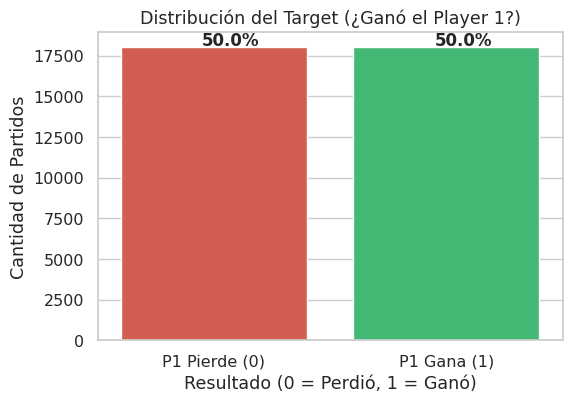

Winner
1    18038
0    18038
Name: count, dtype: int64


In [50]:
# --- VISUALIZACIÓN DEL DATASET BALANCEADO ---

target = 'Winner'


plt.figure(figsize=(6, 4))
ax = sns.countplot(x=target, data=tennis, palette=['#e74c3c', '#2ecc71'])

plt.title('Distribución del Target (¿Ganó el Player 1?)')
plt.xlabel('Resultado (0 = Perdió, 1 = Ganó)')
plt.ylabel('Cantidad de Partidos')
plt.xticks([0, 1], ['P1 Pierde (0)', 'P1 Gana (1)'])

# Añadir etiquetas de porcentaje
total = len(tennis)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2 - 0.05
    y = p.get_height() + 100
    ax.annotate(percentage, (x, y), size=12, weight='bold')

plt.show()

print(tennis[target].value_counts())

---
---

## B.7-Feature engineering (computar diferencias)

In [51]:
def calcular_diferencias_finales(df):
    print("--- Calculando Diferenciales (P1 - P2) y Eliminando Redundantes ---")
    
    # 1. Identificar columnas base para restar
    cols_p1 = [c for c in df.columns if c.startswith('p1_')]
    stats_names = [c.replace('p1_', '') for c in cols_p1]
    
    diff_cols_created = []
    cols_to_drop = [] # Lista de columnas redundantes a eliminar (P1 y P2 originales)
    
    # 2. Bucle de Resta
    for stat in stats_names:
        col_p1 = f"p1_{stat}"
        col_p2 = f"p2_{stat}"
        
        # Solo procesamos si existen las DOS (P1 y P2)
        if col_p1 in df.columns and col_p2 in df.columns:
            
            # Verificamos que sean numéricas para poder restarlas
            # (Excluimos cosas como ID o Nombres si los hubiera)
            if pd.api.types.is_numeric_dtype(df[col_p1]):
                col_diff = f"diff_{stat}"
                
                # A. CALCULAR DIFERENCIA
                df[col_diff] = df[col_p1].fillna(0) - df[col_p2].fillna(0)
                diff_cols_created.append(col_diff)
                
                # B. MARCAR ORIGINALES PARA BORRAR
                # Solo borramos p1_stat y p2_stat si hemos creado su diferencia
                cols_to_drop.append(col_p1)
                cols_to_drop.append(col_p2)

    print(f"✅ Se han generado {len(diff_cols_created)} variables diferenciales.")
    print(f"❌ Se eliminarán {len(cols_to_drop)} variables redundantes (Originales P1/P2).")

    # 3. LIMPIEZA FINAL (Estrategia: Drop)
    # En lugar de seleccionar, borramos las redundantes.
    # Esto MANTIENE cualquier otra columna que no sea p1_stat o p2_stat.
    
    # Protegemos variables 'Tácticas' que NO queremos borrar aunque empiecen por p1_
    # (Por ejemplo: p1_hand, p1_is_rookie, p1_id...)
    # Si alguna de estas entró en la resta (por ser numérica), decidimos si borrarla o no.
    # Generalmente, las stats numéricas (win_rate) se borran, las categóricas se quedan.
    
    # Filtro de seguridad: No borramos IDs ni Flags si no queremos
    # Por defecto, el código de arriba borra todo lo que se restó.
    
    df_final = df.drop(columns=cols_to_drop, errors='ignore')
    
    print(f"🧹 Limpieza completada.")
    print(f"   - Dimensiones originales: {df.shape}")
    print(f"   - Dimensiones finales:    {df_final.shape}")
    
    return df_final

# EJECUTAR
tennis = calcular_diferencias_finales(tennis)

# Verificación
print("\nPrimeras 5 columnas:", tennis.columns.tolist()[:5])

--- Calculando Diferenciales (P1 - P2) y Eliminando Redundantes ---
✅ Se han generado 48 variables diferenciales.
❌ Se eliminarán 96 variables redundantes (Originales P1/P2).
🧹 Limpieza completada.
   - Dimensiones originales: (36076, 171)
   - Dimensiones finales:    (36076, 75)

Primeras 5 columnas: ['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level']


---
---

## B.8-Eliminar data leakage


In [52]:
# --- ELIMINACIÓN DE DATA LEAKAGE (Variables del futuro) ---

# Lista de columnas prohibidas (Generadas durante o después del partido)
cols_leakage = [
    'score',          # El marcador final (obvio)
    'minutes',        # Duración del partido
    'tourney_points', # Puntos ganados por este torneo (se sabe al final)
    'tourney_id',
    'tourney_name',
    'tourney_date', 'month_name',
    
    # Estadísticas de juego Player 1 (Ocurren durante el partido)
    'p1_ace', 'p1_df', 'p1_svpt', 'p1_1stIn', 'p1_1stWon', 'p1_2ndWon', 
    'p1_SvGms', 'p1_bpSaved', 'p1_bpFaced', 'p1_id', 'p1_name', 'p1_ioc',
    
    # Estadísticas de juego Player 2 (Ocurren durante el partido)
    'p2_ace', 'p2_df', 'p2_svpt', 'p2_1stIn', 'p2_1stWon', 'p2_2ndWon', 
    'p2_SvGms', 'p2_bpSaved', 'p2_bpFaced', 'p2_id', 'p2_name', 'p2_ioc'
]

# Verificar qué columnas realmente existen en el DataFrame
cols_existentes = [col for col in cols_leakage if col in tennis.columns]
cols_no_existen = [col for col in cols_leakage if col not in tennis.columns]

print(f"Columnas a eliminar que SÍ existen: {len(cols_existentes)}")
print(f"Columnas que NO se encontraron (ya eliminadas o nunca existieron): {len(cols_no_existen)}")
if cols_no_existen:
    print(f"Columnas no encontradas: {cols_no_existen}")

# Creamos el dataset limpio eliminando solo las columnas que existen
tennis_final = tennis.drop(columns=cols_existentes)

# --- VERIFICACIÓN ---
print(f"\nDimensiones originales: {tennis.shape}")
print(f"Dimensiones limpias (sin leakage): {tennis_final.shape}")
print(f"Columnas eliminadas: {len(cols_existentes)}")

# Copiamos el auxiliar a tennis
tennis = tennis_final

Columnas a eliminar que SÍ existen: 11
Columnas que NO se encontraron (ya eliminadas o nunca existieron): 20
Columnas no encontradas: ['p1_ace', 'p1_df', 'p1_svpt', 'p1_1stIn', 'p1_1stWon', 'p1_2ndWon', 'p1_SvGms', 'p1_bpSaved', 'p1_bpFaced', 'p1_id', 'p2_ace', 'p2_df', 'p2_svpt', 'p2_1stIn', 'p2_1stWon', 'p2_2ndWon', 'p2_SvGms', 'p2_bpSaved', 'p2_bpFaced', 'p2_id']

Dimensiones originales: (36076, 75)
Dimensiones limpias (sin leakage): (36076, 64)
Columnas eliminadas: 11


In [53]:
# 1. ELIMINAR LEAKAGE (Obligatorio)
cols_to_drop = ['n_sets', 'total_tb', 'p1_tb_won', 'p2_tb_won']

# 2. ELIMINAR RUIDO / REDUNDANTES (Recomendado)
# 'match_num' suele sobrar si tienes 'round'. 
# 'seed' suele sobrar si tienes 'is_seeded' y 'rank'.
cols_to_drop += ['match_num', 'p1_seed', 'p2_seed'] 

# Aplicar borrado
tennis_clean = tennis.drop(columns=cols_to_drop, errors='ignore')

print(f"Dimensiones finales listas para ML: {tennis_clean.shape}")

Dimensiones finales listas para ML: (36076, 61)


In [54]:
def limpiar_leakage_final(df):
    print("--- 🧹 LIMPIEZA FINAL DE LEAKAGE Y BASURA ---")
    
    # 1. LEAKAGE (Trampas del futuro: Stats del partido de HOY)
    leakage_cols = [
        'n_sets', 'total_tb', 'diff_tb_won', # Resultado puro
        'diff_ace', 'diff_df', 'diff_svpt',  # Stats crudas de hoy
        'diff_1stIn', 'diff_1stWon', 'diff_2ndWon', 
        'diff_SvGms', 'diff_bpSaved', 'diff_bpFaced'
    ]
    
    # 2. SIN SENTIDO (Ids)
    nonsense_cols = ['diff_id', 'diff_seed']
    
    # 3. RUIDO (Administrativo)
    noise_cols = ['match_num', 'month', 'day']
    
    # Unimos todas las listas
    cols_to_drop = leakage_cols + nonsense_cols + noise_cols
    
    # Borramos solo si existen
    cols_to_drop = [c for c in cols_to_drop if c in df.columns]
    
    df_clean = df.drop(columns=cols_to_drop)
    
    print(f"❌ Se han eliminado {len(cols_to_drop)} variables prohibidas.")
    print(f"   - Eliminadas: {cols_to_drop}")
    print(f"✅ Dimensiones finales seguras: {df_clean.shape}")
    
    return df_clean

# EJECUTAR
tennis = limpiar_leakage_final(tennis)

--- 🧹 LIMPIEZA FINAL DE LEAKAGE Y BASURA ---
❌ Se han eliminado 17 variables prohibidas.
   - Eliminadas: ['n_sets', 'total_tb', 'diff_tb_won', 'diff_ace', 'diff_df', 'diff_svpt', 'diff_1stIn', 'diff_1stWon', 'diff_2ndWon', 'diff_SvGms', 'diff_bpSaved', 'diff_bpFaced', 'diff_id', 'diff_seed', 'match_num', 'month', 'day']
✅ Dimensiones finales seguras: (36076, 47)


<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Fase C-Separación de los datos

## C.1-División del dataset en train/test 

In [56]:
# --- C.1 DIVISIÓN TRAIN / TEST (Series Temporales) ---

# 2. Definir el punto de corte
corte = 2020

# 3. Realizar el corte
tennis_train = tennis[tennis['year'] <= corte].copy()
tennis_test  = tennis[tennis['year'] > corte].copy()

# 4. Eliminar la columna auxiliar 'year' y 'tourney_date' SI YA NO LAS QUIERES
# (Ahora sí podemos borrarlas porque ya sirvieron para separar)
cols_to_drop = ['year']
tennis_train.drop(columns=cols_to_drop, inplace=True) # Descomenta si quieres borrarlas ya
tennis_test.drop(columns=cols_to_drop, inplace=True)

# --- VERIFICACIÓN ---
print(f"--- Dimensiones ---")
print(f"Train Set (2011-2020): {tennis_train.shape[0]} partidos ({(len(tennis_train)/len(tennis))*100:.1f}%)")
print(f"Test Set  (2021-2024): {tennis_test.shape[0]} partidos ({(len(tennis_test)/len(tennis))*100:.1f}%)")

print(f"\n--- Balance del Target (Debe ser 50/50 en ambos) ---")
print(f"Train Target=1: {tennis_train[target].mean():.3f}")
print(f"Test Target=1:  {tennis_test[target].mean():.3f}")

print(tennis.columns.tolist())


--- Dimensiones ---
Train Set (2011-2020): 25155 partidos (69.7%)
Test Set  (2021-2024): 10921 partidos (30.3%)

--- Balance del Target (Debe ser 50/50 en ambos) ---
Train Target=1: 0.498
Test Target=1:  0.504
['surface', 'draw_size', 'tourney_level', 'p1_entry', 'p1_hand', 'p2_entry', 'p2_hand', 'best_of', 'round', 'year', 'Winner', 'diff_ht', 'diff_age', 'diff_rank', 'diff_rank_points', 'diff_h2h', 'diff_is_seeded', 'diff_is_first_match', 'diff_tb_rate_last_5', 'diff_1st_won_pct_last_1', 'diff_bp_save_pct_last_1', 'diff_tb_won_pct_last_10', 'diff_tb_rate_last_10', 'diff_df_pct_lifetime', 'diff_df_pct_last_10', 'diff_win_rate_last_10', 'diff_is_rookie', 'diff_bp_save_pct_last_5', 'diff_df_pct_last_5', 'diff_ace_pct_last_5', 'diff_1st_won_pct_lifetime', 'diff_tb_rate_lifetime', 'diff_ace_pct_lifetime', 'diff_win_rate_lifetime', 'diff_df_pct_last_1', 'diff_1st_won_pct_last_10', 'diff_1st_won_pct_last_5', 'diff_bp_save_pct_last_10', 'diff_win_rate_last_5', 'diff_tb_rate_last_1', 'diff_bp

<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Fase D-Análisis

## D.1-Exploratorio Mínimo

### D.1.1-Introducción al problema

En este dataset, tenemos múltiples variables explicativas que parece razonable pensar que afectan al ganador de un partido de tenis.



In [57]:
tennis_train.shape, tennis_test.shape, tennis.shape

((25155, 46), (10921, 46), (36076, 47))

Vemos que tenemos los datos de 36046 partidos, para cada persona hay 24 variables que pueden ser significativas. Tras la división 25125 para entrenamiento y 10921 para el de test.

### D.1.2-Formulación del problema

Este es un problema de clasificación, ya que la variable objetivo es el ganador de un partido de tennis, que puede ser:



In [58]:
tennis_train['Winner'].value_counts()


Winner
0    12617
1    12538
Name: count, dtype: int64

### D.5.3-Preparación de los datos

Vamos a definir las variables X e y (explicativa y objetivo respectivamente).

Como podemos ver en la tabla, en este dataset hay tanto variables numéricas como categóricas.

In [59]:
target = 'Winner'

features = tennis_train.columns.drop(target).tolist()
numerical_features = tennis_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = tennis_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Eliminar el target de las numéricas (ya está como 0 o 1)
numerical_features.remove(target)

print("--- Clasificación de Variables ---")
print(f"Target: {target}")
print(f"Numéricas ({len(numerical_features)}): {numerical_features}")
print(f"Categóricas ({len(categorical_features)}): {categorical_features}")

--- Clasificación de Variables ---
Target: Winner
Numéricas (38): ['draw_size', 'best_of', 'diff_ht', 'diff_age', 'diff_rank', 'diff_rank_points', 'diff_h2h', 'diff_is_seeded', 'diff_is_first_match', 'diff_tb_rate_last_5', 'diff_1st_won_pct_last_1', 'diff_bp_save_pct_last_1', 'diff_tb_won_pct_last_10', 'diff_tb_rate_last_10', 'diff_df_pct_lifetime', 'diff_df_pct_last_10', 'diff_win_rate_last_10', 'diff_is_rookie', 'diff_bp_save_pct_last_5', 'diff_df_pct_last_5', 'diff_ace_pct_last_5', 'diff_1st_won_pct_lifetime', 'diff_tb_rate_lifetime', 'diff_ace_pct_lifetime', 'diff_win_rate_lifetime', 'diff_df_pct_last_1', 'diff_1st_won_pct_last_10', 'diff_1st_won_pct_last_5', 'diff_bp_save_pct_last_10', 'diff_win_rate_last_5', 'diff_tb_rate_last_1', 'diff_bp_save_pct_lifetime', 'diff_ace_pct_last_10', 'diff_win_rate_last_1', 'diff_tb_won_pct_last_1', 'diff_tb_won_pct_lifetime', 'diff_ace_pct_last_1', 'diff_tb_won_pct_last_5']
Categóricas (7): ['surface', 'tourney_level', 'p1_entry', 'p1_hand', 'p2_

### D.5.4-Entrando en detalle con la variable objetivo

Hemos visto anteriormente que $Winner$ es una categórica con 3 categorías. Vamos a ver si hay alguna que sobresale de las otras y ver la distribución que sigue.

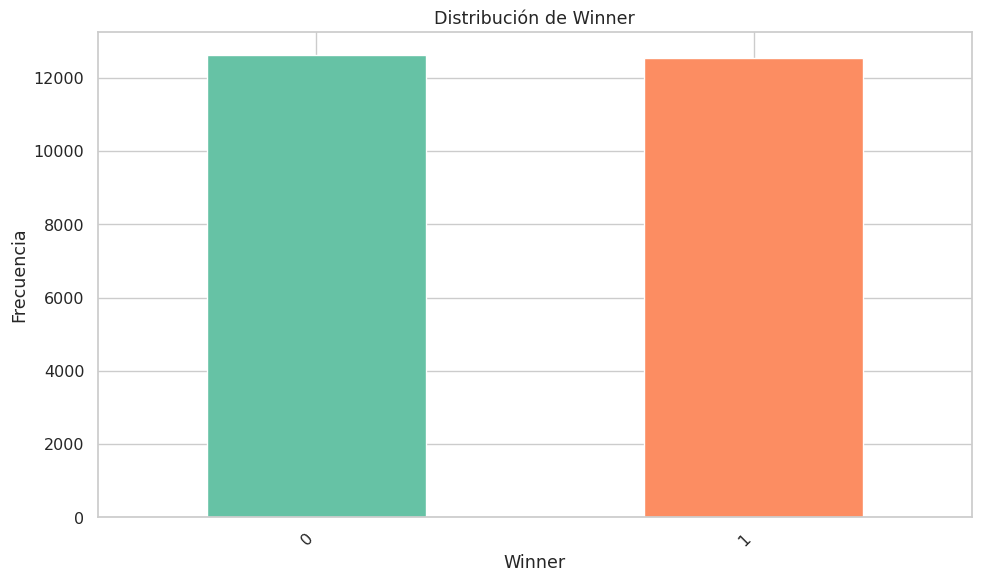

In [60]:
plt.figure(figsize=(10, 6))
counts = tennis_train[target].value_counts()
palette = sns.color_palette("Set2", n_colors=len(counts)) 
ax = counts.plot(kind='bar', color=palette)
ax.set_title('Distribución de Winner')
ax.set_xlabel('Winner')
ax.set_ylabel('Frecuencia')
ax.set_xticklabels(counts.index, rotation=45, ha='right')  # roto etiquetas para que se lean
plt.tight_layout()
plt.show()

### D.5.5-Variables Explicativas

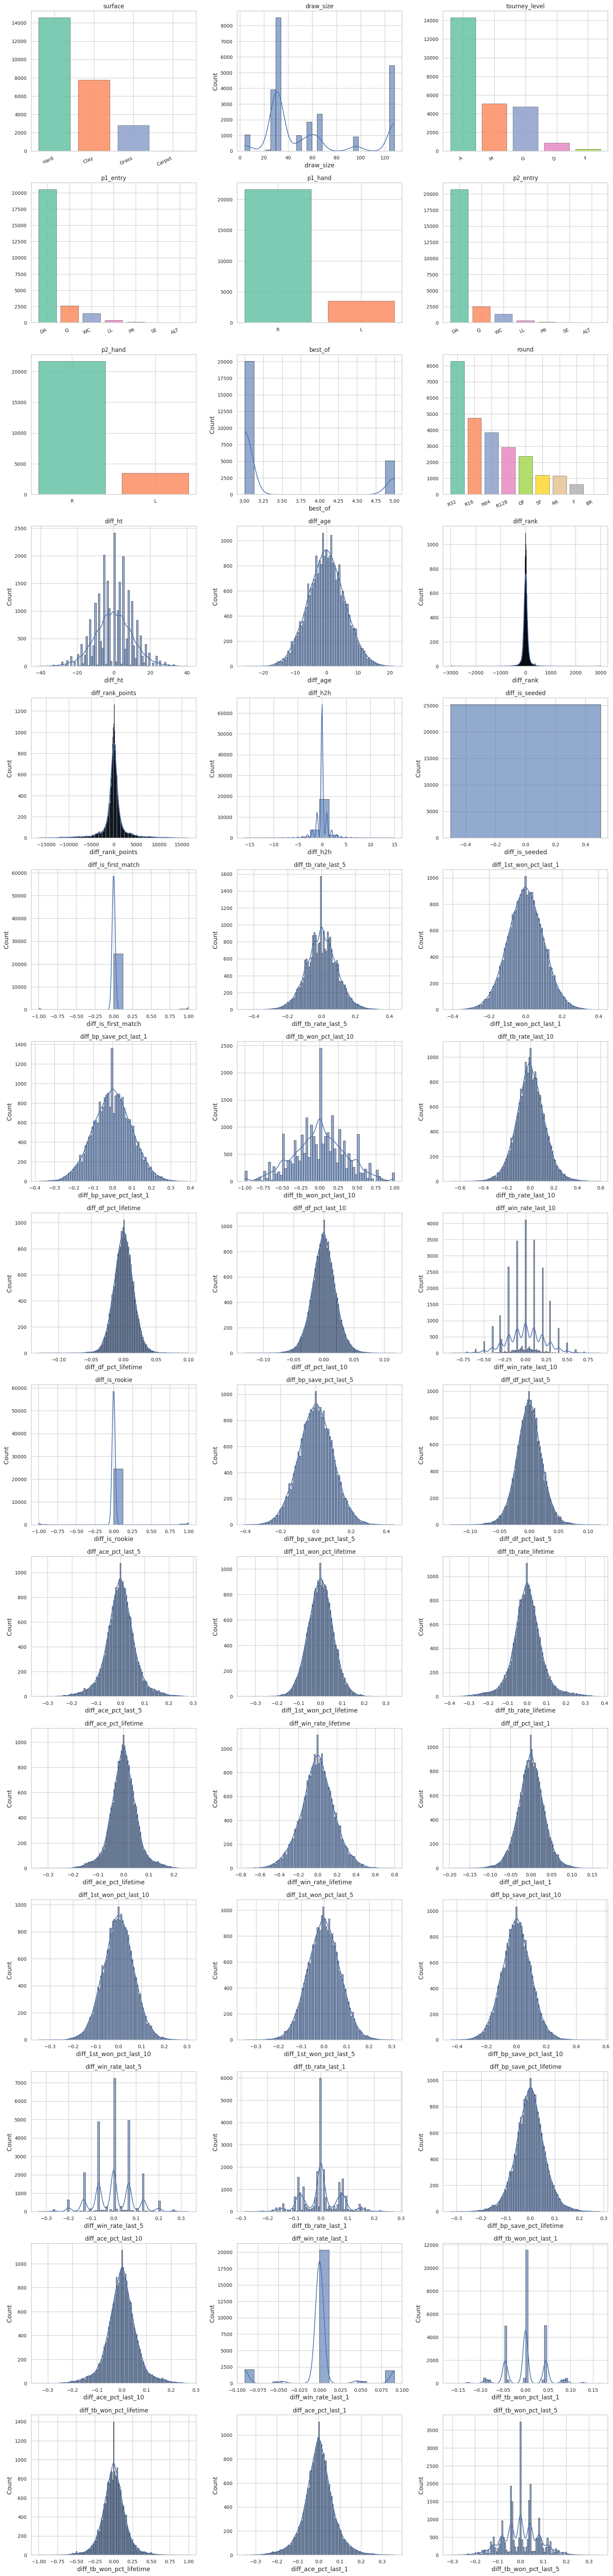

In [61]:
import math
n_rows = math.ceil(len(features) / 3)

fig, axes = plt.subplots(n_rows, 3, figsize=(18, n_rows * 5))
axes = axes.flatten()

for i, col in enumerate(features):
    ax = axes[i]
    if pd.api.types.is_numeric_dtype(tennis_train[col]):
        # Numéricas
        sns.histplot(
            data=tennis_train,
            x=col,
            kde=True,
            ax=ax,
            stat='count',
            alpha=0.6,
            edgecolor="black",
            linewidth=0.5
        )
    else:
        # Categóricas
        vc = tennis_train[col].value_counts()
        categories = vc.index.astype(str)
        counts = vc.values
        colors = sns.color_palette("Set2", n_colors=len(categories))
        ax.bar(categories, counts, color=colors, alpha=0.85, edgecolor='black', linewidth=0.4)
        if len(categories) > 3:
            plt.setp(ax.get_xticklabels(), rotation=25, ha='right')

    ax.set_title(col, fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)

for j in range(len(features), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### A.5.5.1-Correlación con la variable objetivo $Winner$

En esta sección, analizaremos la relación entre cada variable explicativa y nuestra variable objetivo, $Winner$, para identificar los predictores más influyentes.

### A.5.5.2-Correlaciones por separado

#### Variables Numéricas

Para las variables numéricas miraré la correlacion haciendo un scatter plot para mostrar la relación entre las variables numéricas y la variable objetivo, junto con la H de Kruskal y el p-value.

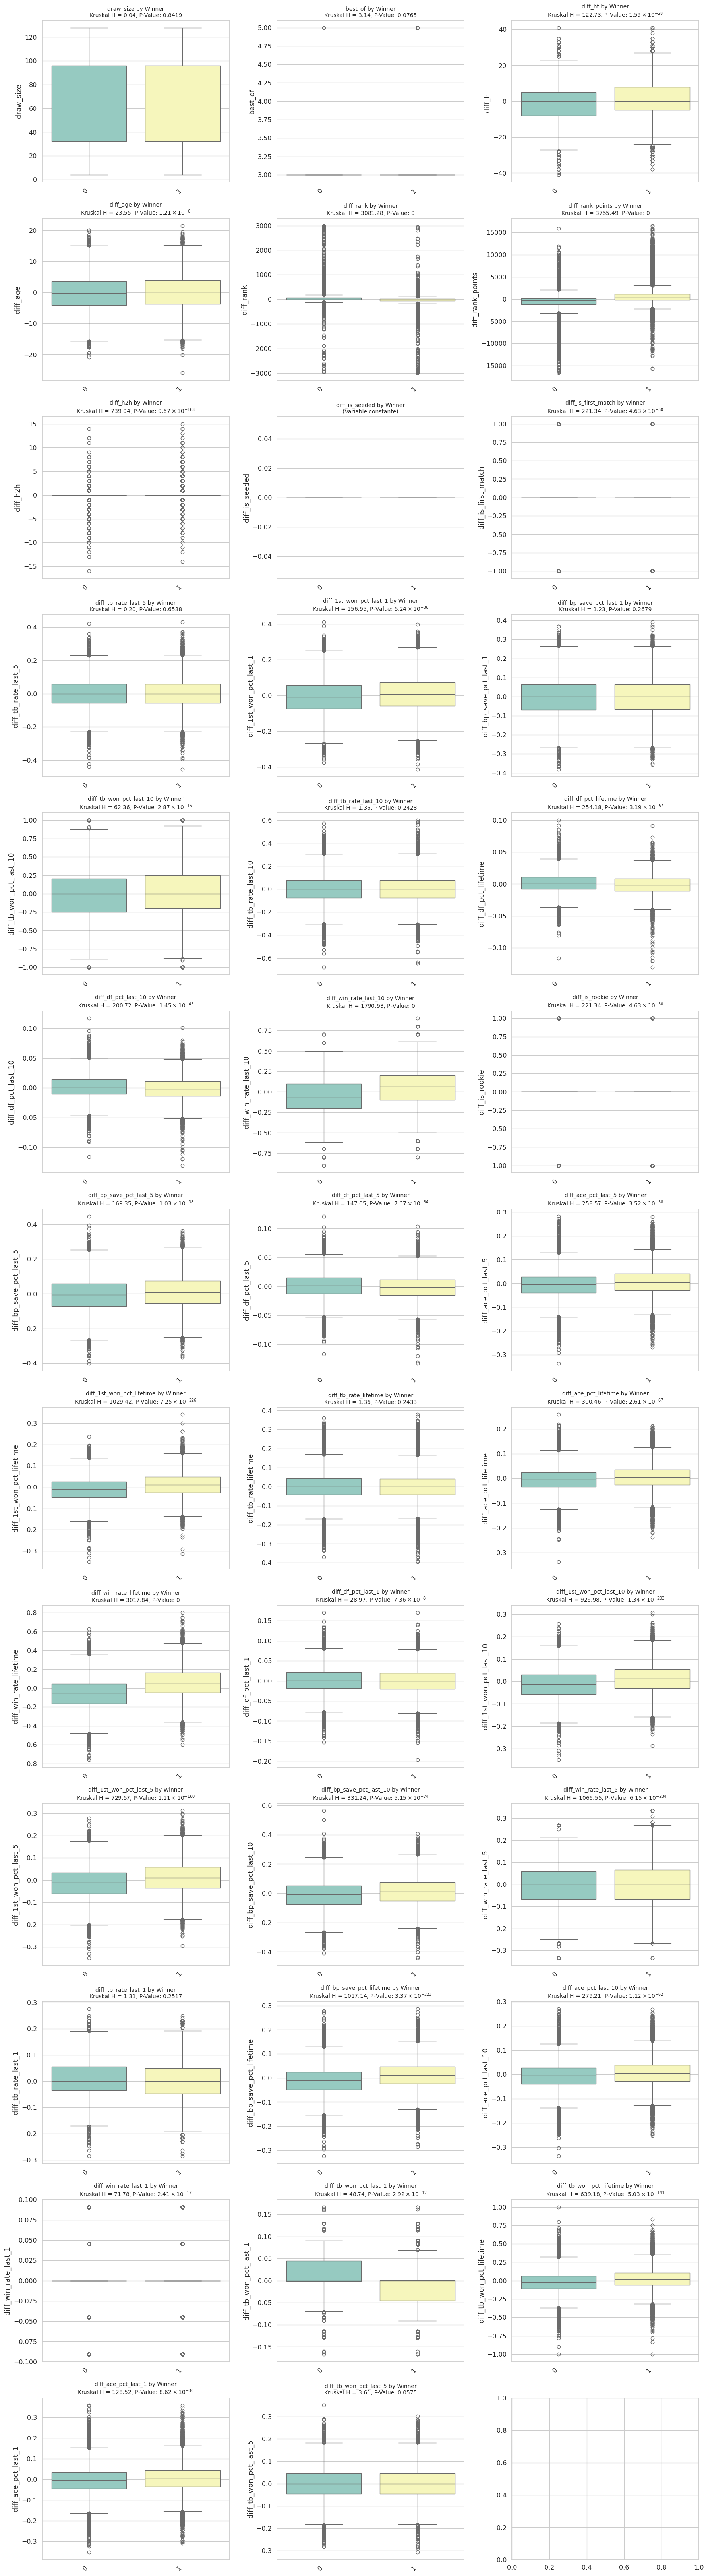

In [62]:
n_rows = math.ceil(len(numerical_features) / 3)
fig, axes = plt.subplots(n_rows, 3, figsize=(18, n_rows * 5))
order = tennis_train[target].value_counts().index.tolist()
n_cat = len(order)
palette = sns.color_palette("Set3", n_colors=n_cat)

for ax, var in zip(axes.flatten(), numerical_features):
    
    sns.boxplot(x=target, y=var, data=tennis_train, order=order,
                hue=target, dodge=False, palette=palette, ax=ax)

    if ax.get_legend() is not None:
        ax.legend_.remove()

    ax.set_xlabel('')
    ax.set_ylabel(var)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    groups = [g[var].dropna().values for _, g in tennis_train.groupby(target)]
    
    # Verificar que hay grupos válidos Y que hay variabilidad
    if all(len(g) > 0 for g in groups):
        # Comprobar si hay variabilidad (no todos los valores son iguales)
        all_values = np.concatenate(groups)
        if len(np.unique(all_values)) > 1:  # Más de un valor único
            try:
                h, p = stats.kruskal(*groups)
                p_str = format_pval(p)
                ax.set_title(f"{var} by {target}\nKruskal H = {h:.2f}, P-Value: {p_str}", fontsize=10)
            except ValueError:
                ax.set_title(f"{var} by {target}\n(No hay variabilidad suficiente)", fontsize=10)
        else:
            ax.set_title(f"{var} by {target}\n(Variable constante)", fontsize=10)
    else:
        ax.set_title(f"{var} by {target}", fontsize=10)

plt.tight_layout()
plt.show()

#### Variables Categóricas

Para las variables categóricas miraré la correlacion haciendo un bar plot para mostrar la relación entre las variables numéricas y la variable objetivo, junto con el p-value.

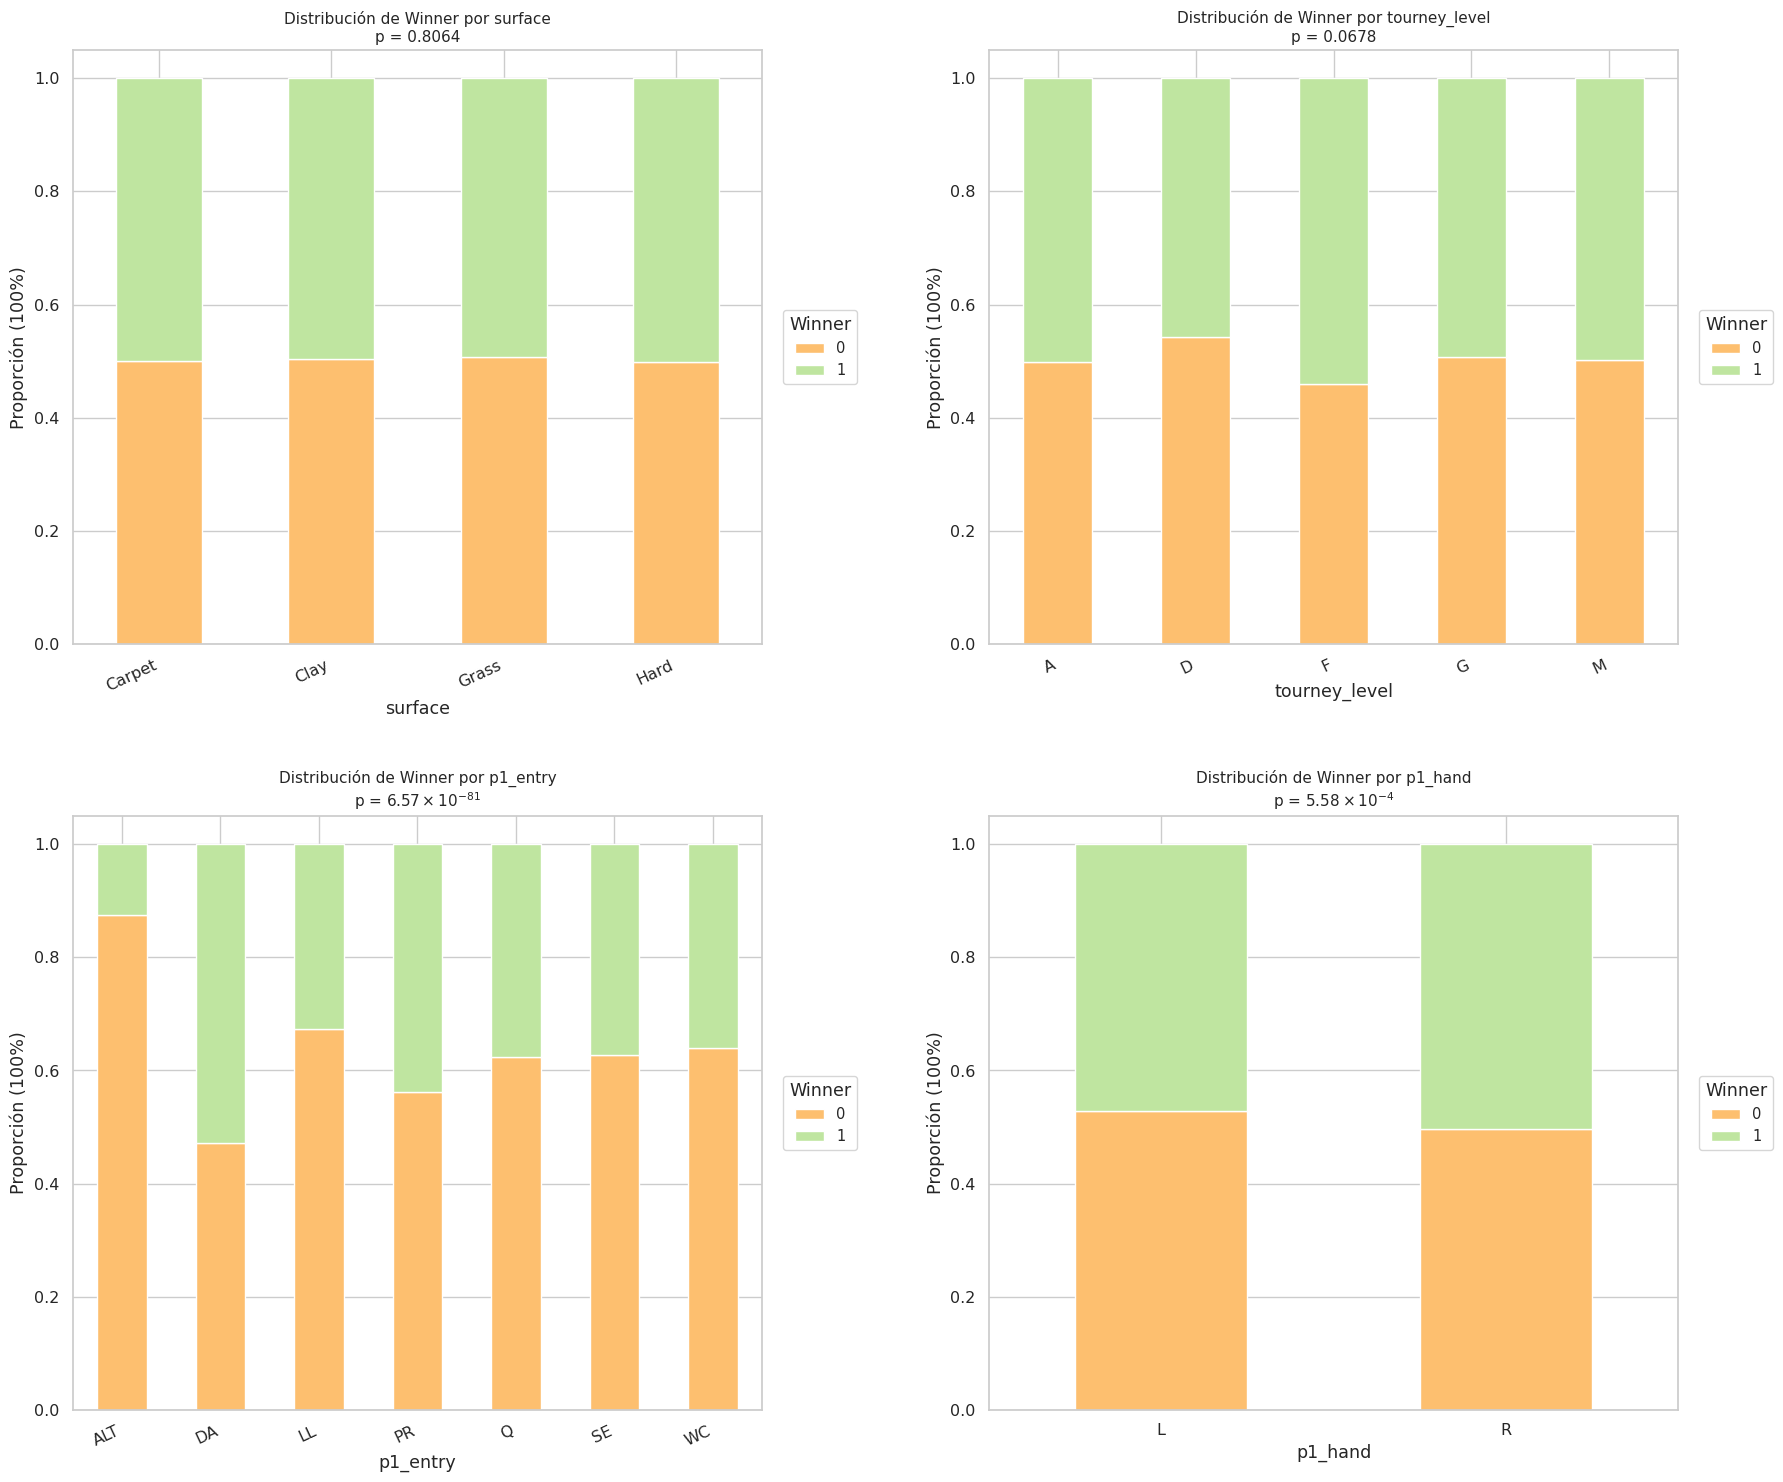

In [63]:
n_rows = math.ceil(len(categorical_features) / 3)
fig, axes = plt.subplots(2,2, figsize=(18, n_rows*5)) 
axes = axes.flatten()
palette = sns.color_palette("Spectral", n_colors=len(tennis_train[target].unique()))

for ax, var in zip(axes, categorical_features):
    ct = pd.crosstab(tennis_train[var], tennis_train[target])
    try:
        chi2, p, dof, ex = stats.chi2_contingency(ct)
        p_str = format_pval(p)
    except Exception:
        p_str = "NA"

    ct_norm = ct.apply(lambda r: r / r.sum(), axis=1)
    colors = palette[:ct_norm.shape[1]]
    ct_norm.plot(kind='bar', stacked=True, ax=ax, color=colors)

    ax.set_title(f"Distribución de {target} por {var}\np = {p_str}", fontsize=11)
    ax.set_xlabel(var)
    ax.set_ylabel("Proporción (100%)")
    if len(ct_norm.index) > 3:
        plt.setp(ax.get_xticklabels(), rotation=25, ha='right')
    else:
        plt.setp(ax.get_xticklabels(), rotation=0)
    ax.legend(title=target, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize='small')
for ax in axes[len(categorical_features):]:
    ax.axis('off')

plt.tight_layout(w_pad=4.0, h_pad=3.0)
plt.show()

### D.5.3-Matriz de correlaciones


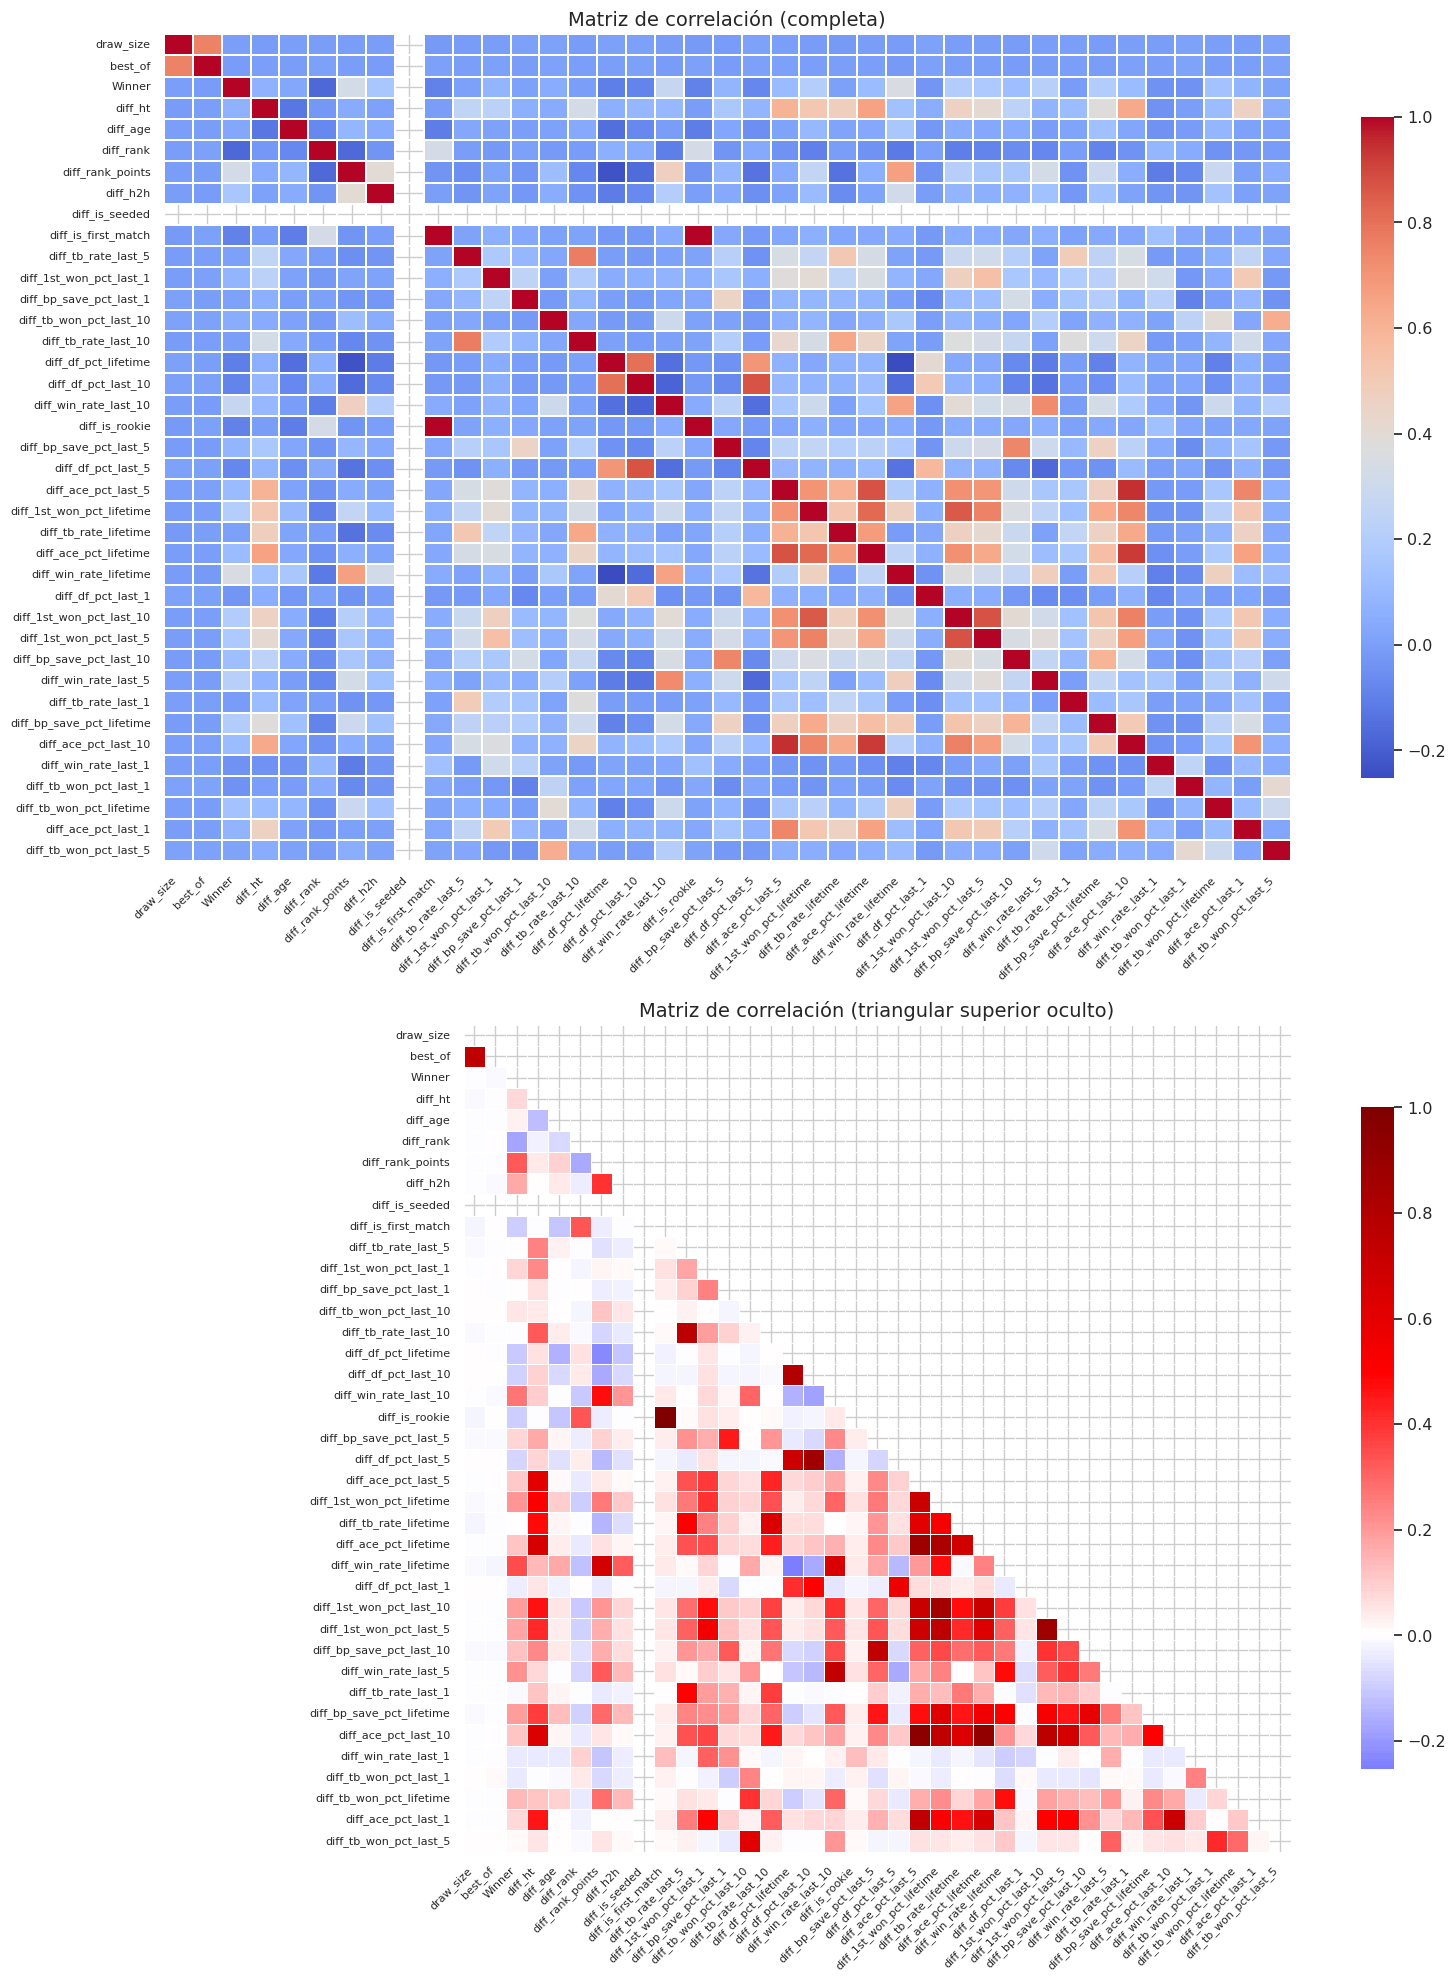

In [64]:
correlation_matrix = tennis_train.corr(numeric_only=True)   
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

fig, axes = plt.subplots(2, 1, figsize=(16, 20))

# Izquierda: SIN anotaciones (son demasiadas variables)
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", ax=axes[0], 
            cbar_kws={"shrink": .8}, linewidths=0.1)
axes[0].set_title("Matriz de correlación (completa)", fontsize=14)
plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right", fontsize=8)
plt.setp(axes[0].get_yticklabels(), fontsize=8)

# Derecha: CON anotaciones (solo mitad superior)
sns.heatmap(correlation_matrix, mask=mask, annot=False, fmt=".2f", 
            cmap='seismic', center=0, square=True, linewidths=.5, 
            cbar_kws={"shrink": .8}, ax=axes[1])
axes[1].set_title("Matriz de correlación (triangular superior oculto)", fontsize=14)
plt.setp(axes[1].get_xticklabels(), rotation=45, ha="right", fontsize=8)
plt.setp(axes[1].get_yticklabels(), fontsize=8)

plt.tight_layout()
plt.show()

<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Fase Final: Guardar dataset limpio



In [65]:
tennis_train.to_parquet("data/clean/atp_matches_train.parquet", index=False)
tennis_test.to_parquet("data/clean/atp_matches_test.parquet", index=False)

<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Tiempo total de ejecución

In [ ]:
print(f"Total Running time {timedelta(seconds=(time() - init_time))}")

Total Running time 0:01:06.818486


: 